<a href="https://www.kaggle.com/code/seanandrie/ps-s3-e25-regression-with-pytorch-lightning?scriptVersionId=167054517" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import warnings
warnings.simplefilter('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

from torch.utils.data import Dataset, DataLoader
from torchmetrics import Metric
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor

sns.set(style = 'whitegrid', palette = 'Set2')

# 2. Fetching Data

In [2]:
orig_path = '/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/'
path = '/kaggle/input/playground-series-s3e25/'

mineral_data = pd.read_csv(orig_path + 'Mineral_Dataset_Supplementary_Info.csv').drop('Unnamed: 0', axis = 1)
artif_cryst = pd.read_csv(orig_path + 'Artificial_Crystals_Dataset.csv').drop(['Unnamed: 0', 'Formula', 'Crystal structure'], axis= 1)
artif_cryst.rename(columns = {'Hardness (Mohs)' : 'Hardness'}, inplace = True)

combined_orig = pd.concat([mineral_data, artif_cryst])
# reposition 'Hardness' column to right-most index
combined_orig = combined_orig[[col for col in combined_orig.columns if col not in ['Hardness']] + ['Hardness']]  

train_data = pd.read_csv(path + 'train.csv').drop('id', axis = 1)
test_data = pd.read_csv(path + 'test.csv').drop('id', axis = 1)
ss = pd.read_csv(path + 'sample_submission.csv')

# 3. Exploratory Data Analysis

In [3]:
def generate_hist_box_plots(data, bins = 25, kde = True, figsize = (15, 25)):
    nrows, ncols = len(data.columns), 2
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize)
    
    for idx, col in enumerate(data.columns):
        plt.subplot(nrows, ncols, ncols*idx+1)
        sns.histplot(data, x = col, bins = bins, kde = kde)
        
        plt.subplot(nrows, ncols, ncols*idx+2)
        sns.boxplot(data, x = col, orient = 'h')

    fig.tight_layout()
    plt.show()

## Numerical Feature Distributions by Dataset

## Playground Data

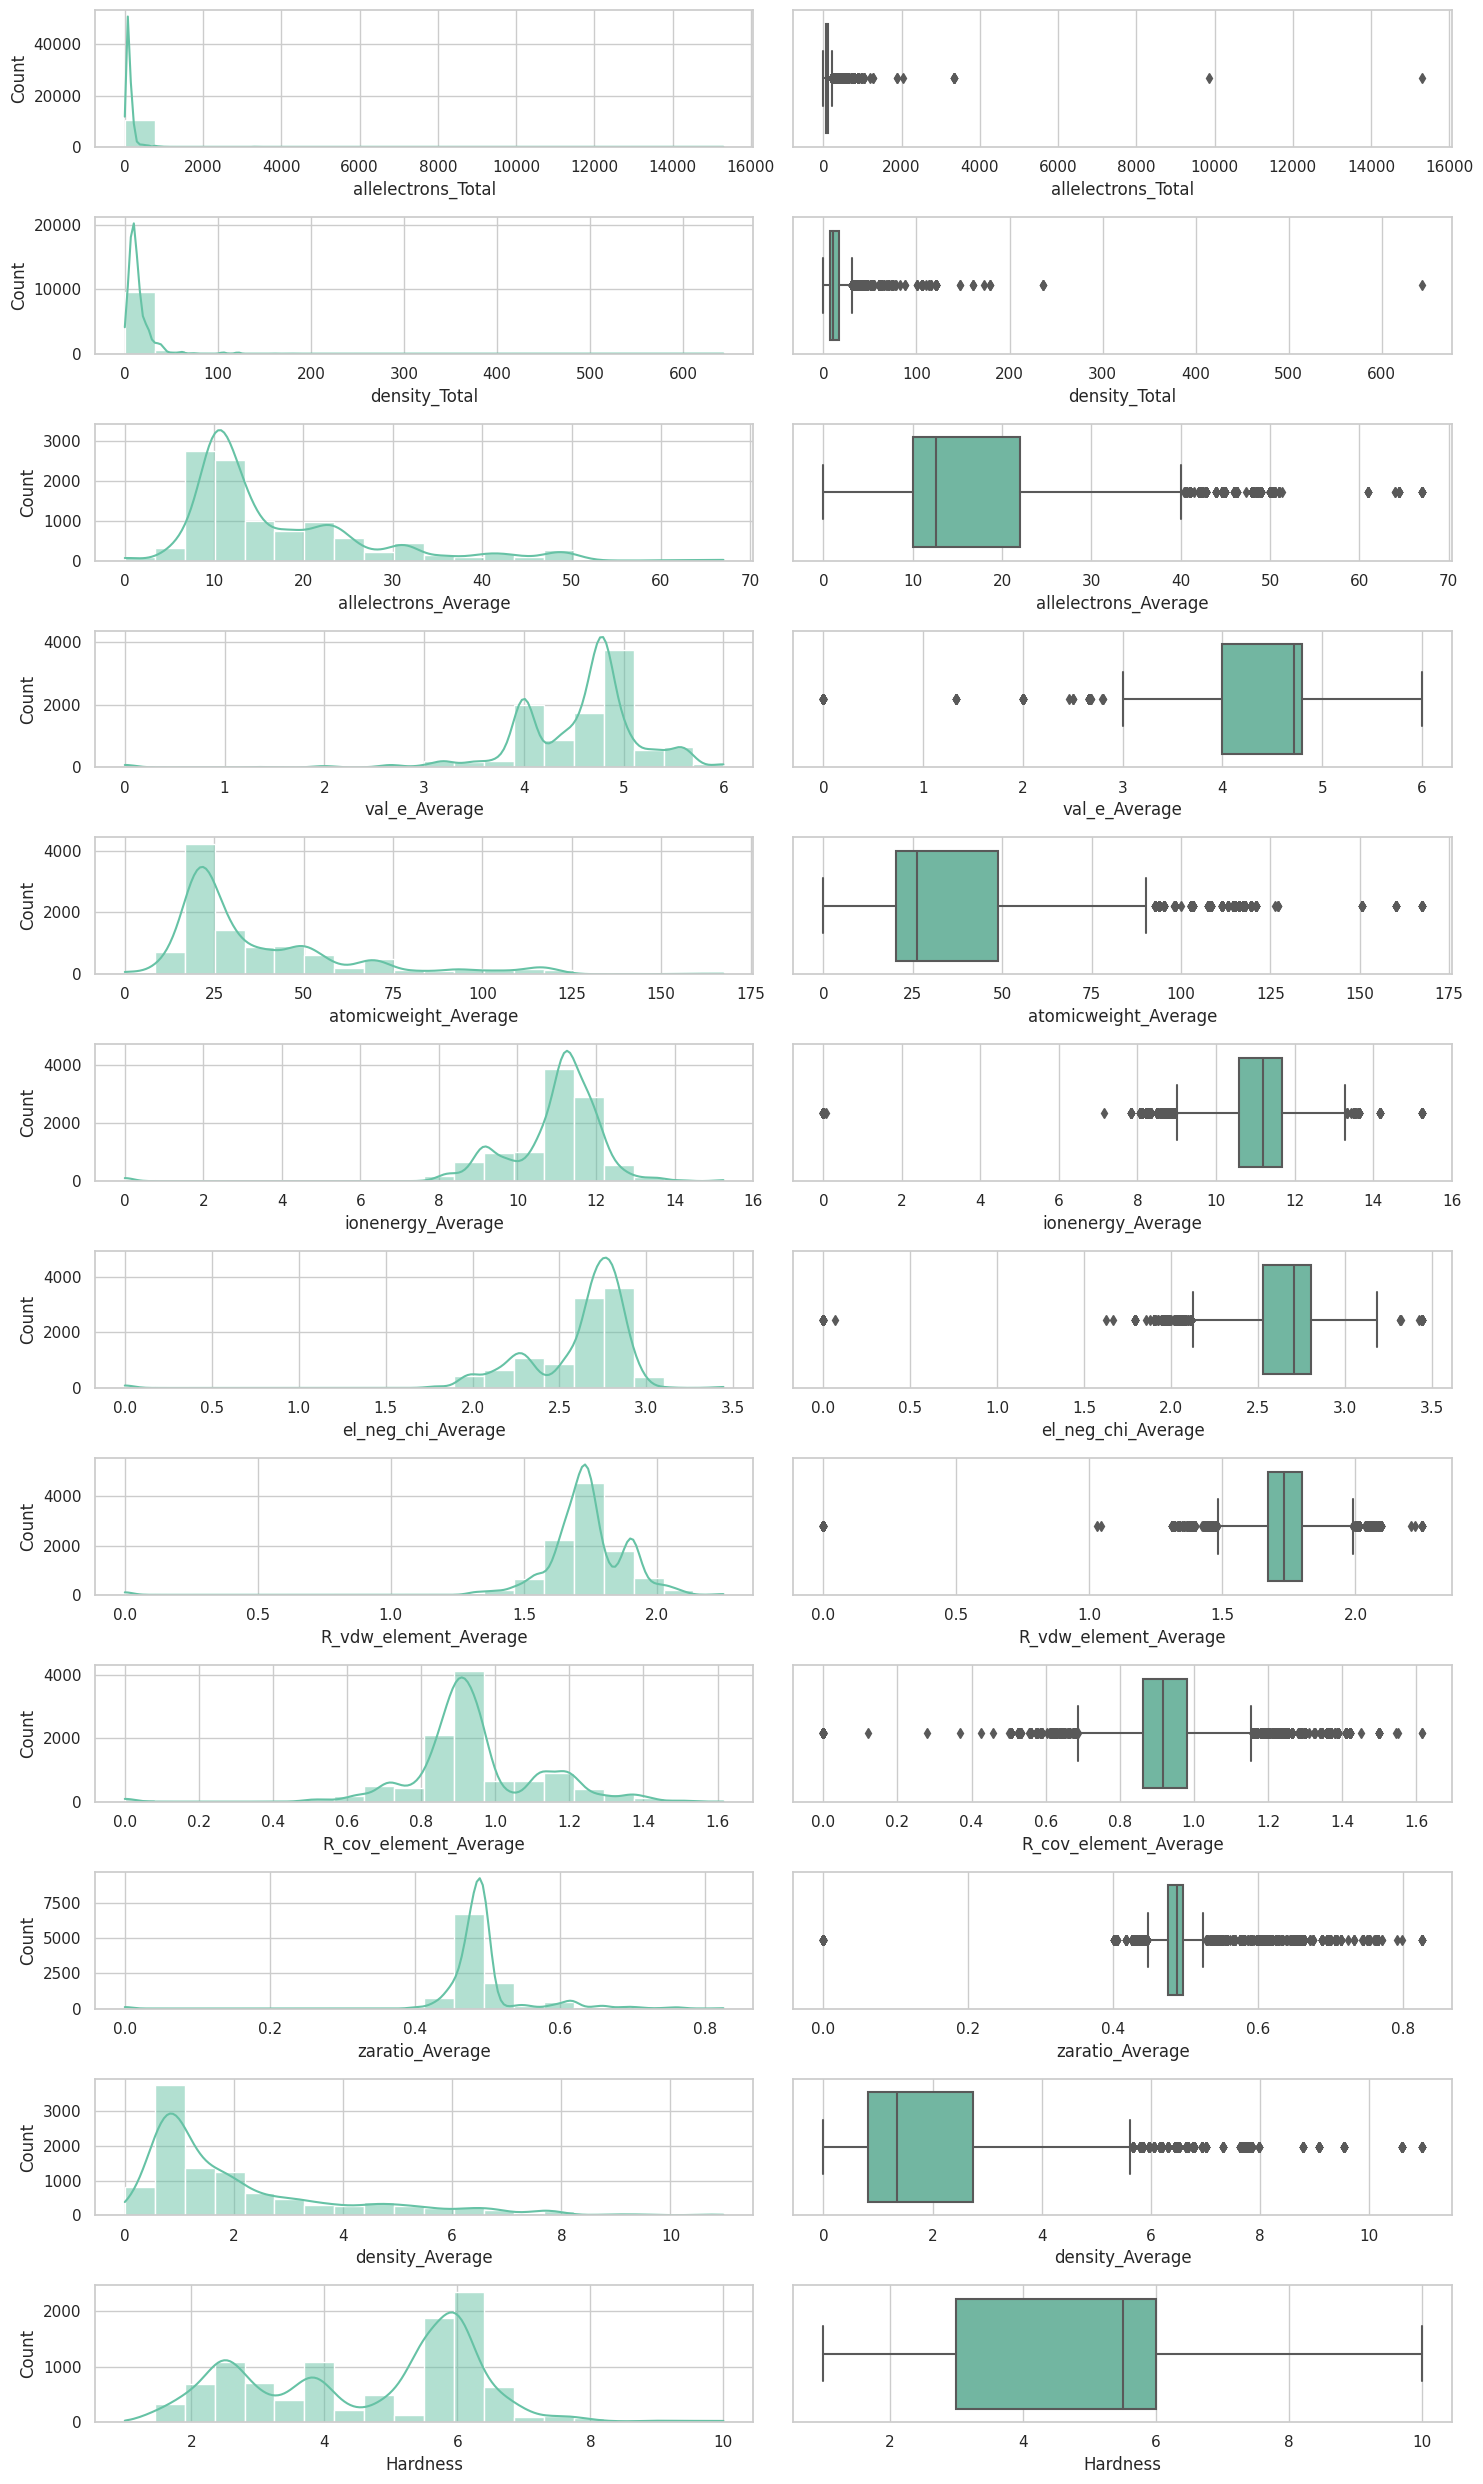

In [4]:
generate_hist_box_plots(train_data, bins = 20)

## Original Data 

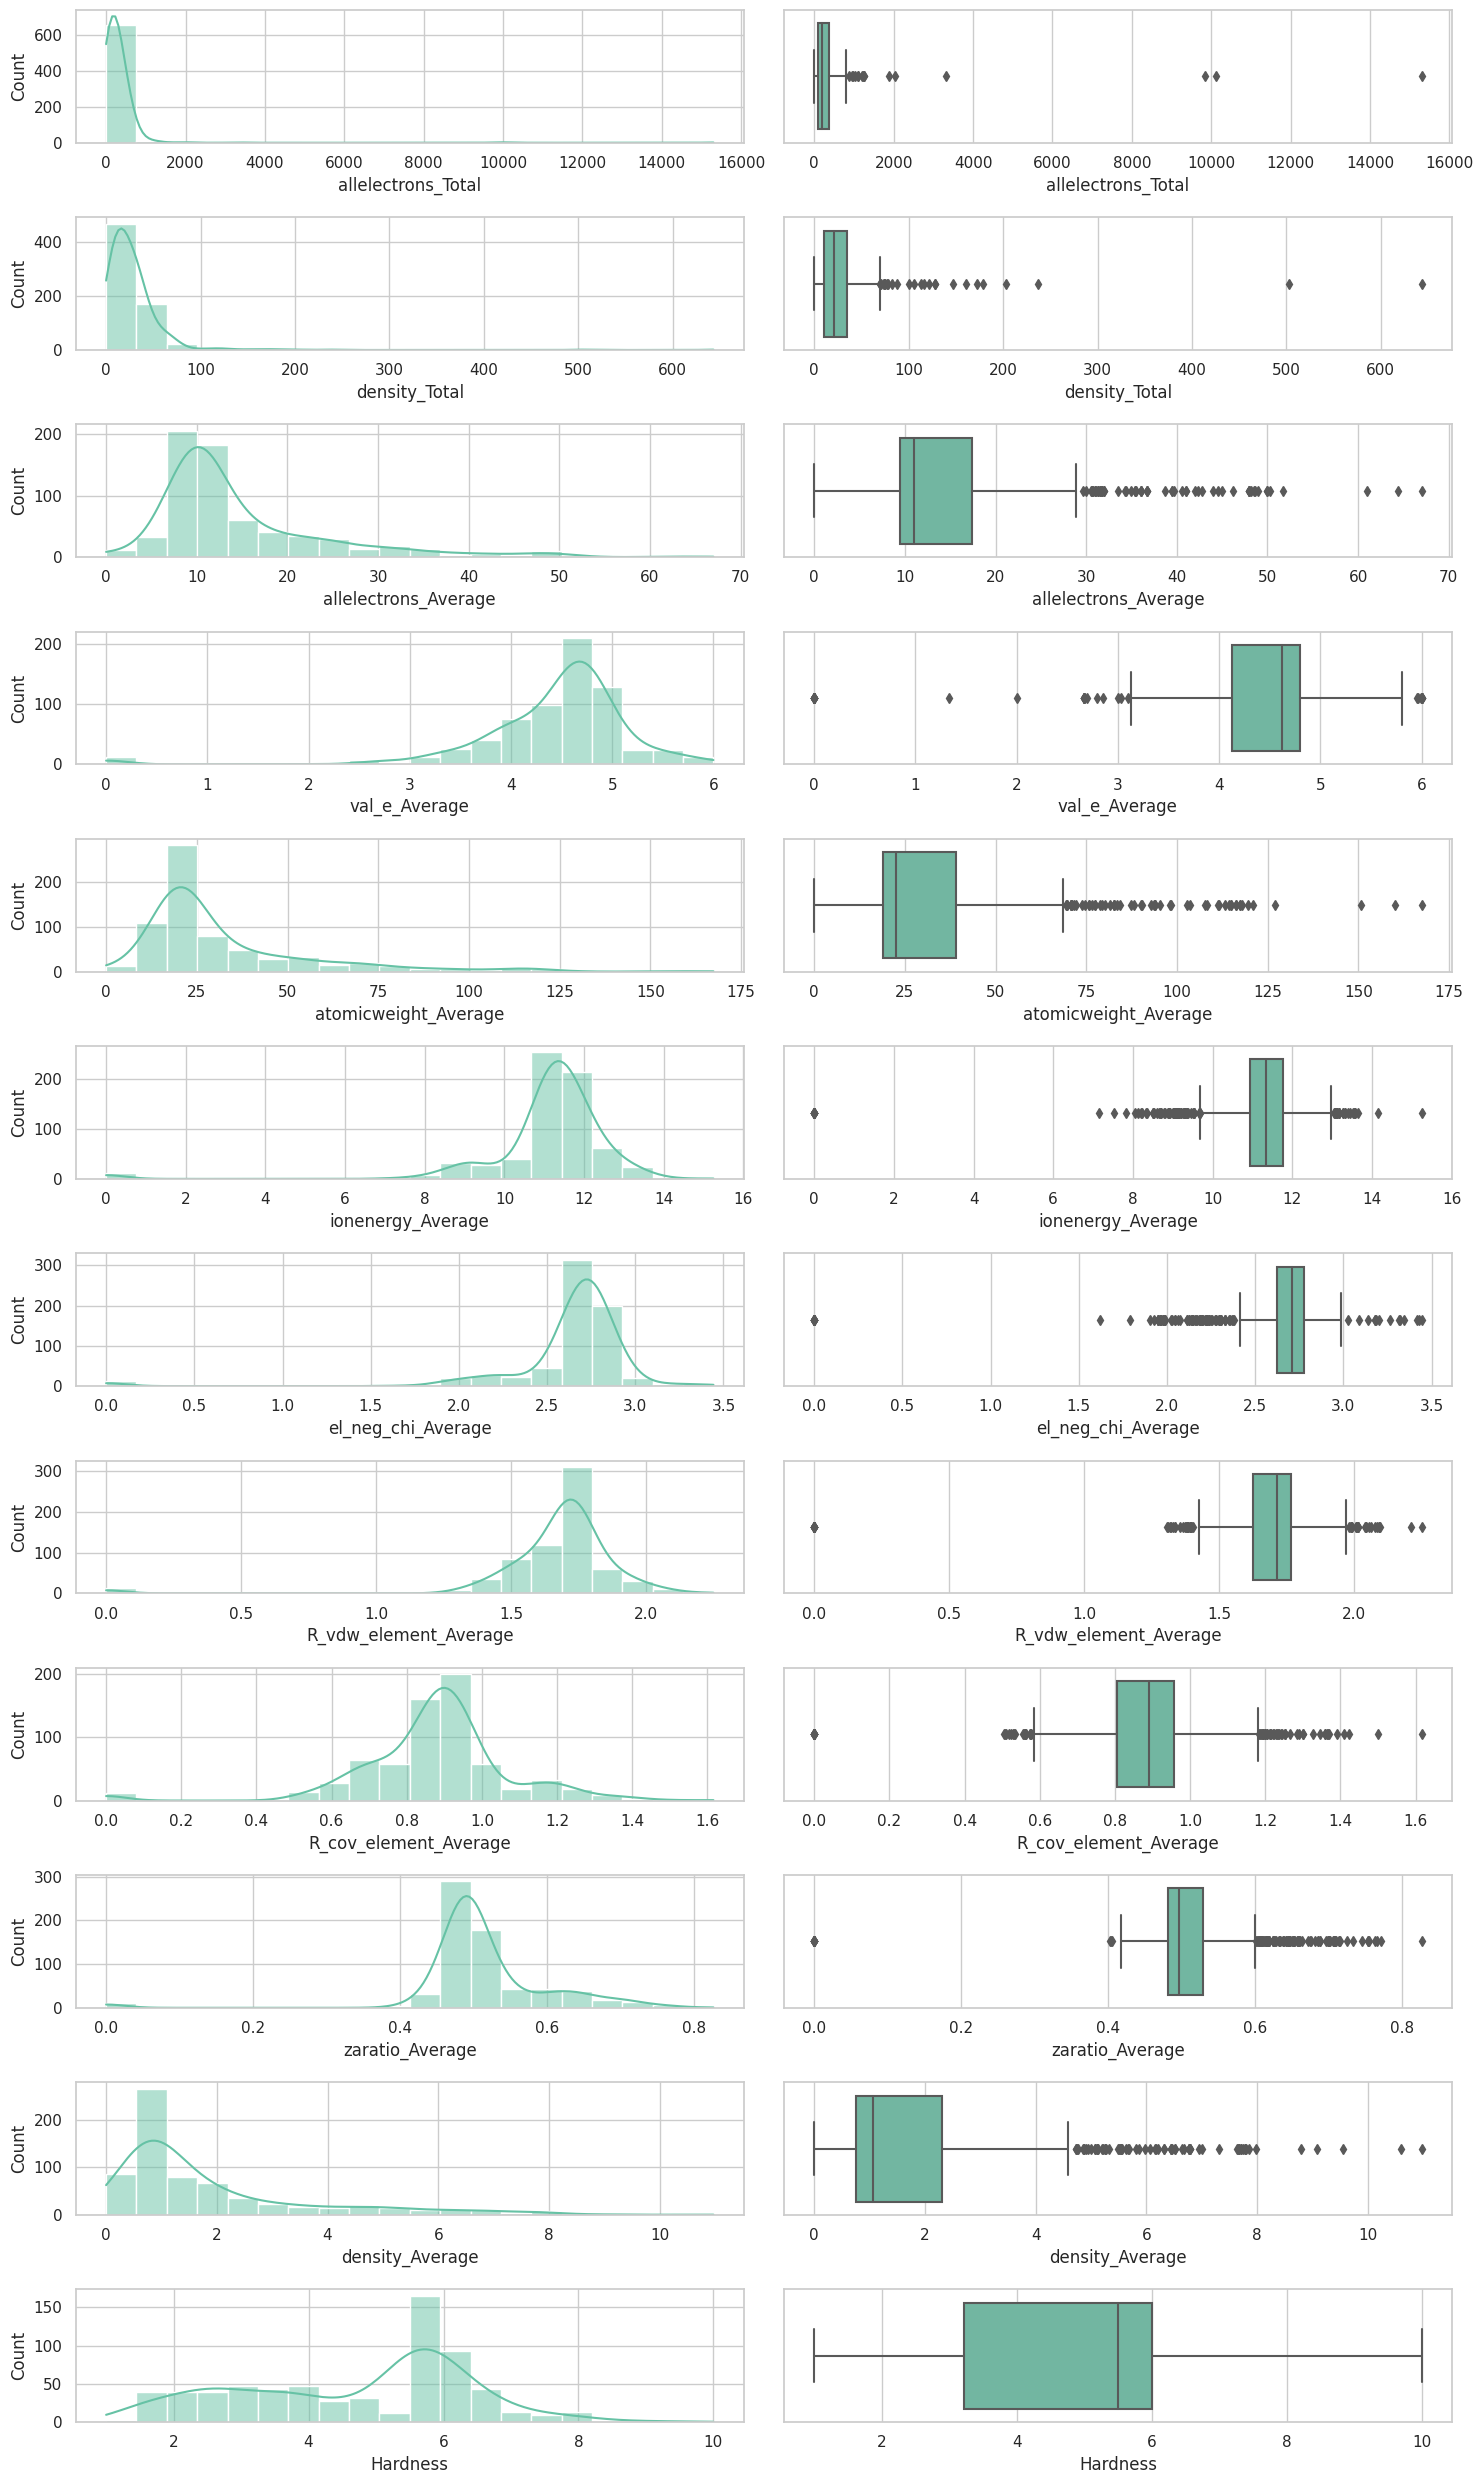

In [5]:
generate_hist_box_plots(combined_orig, bins = 20)

## Test Data

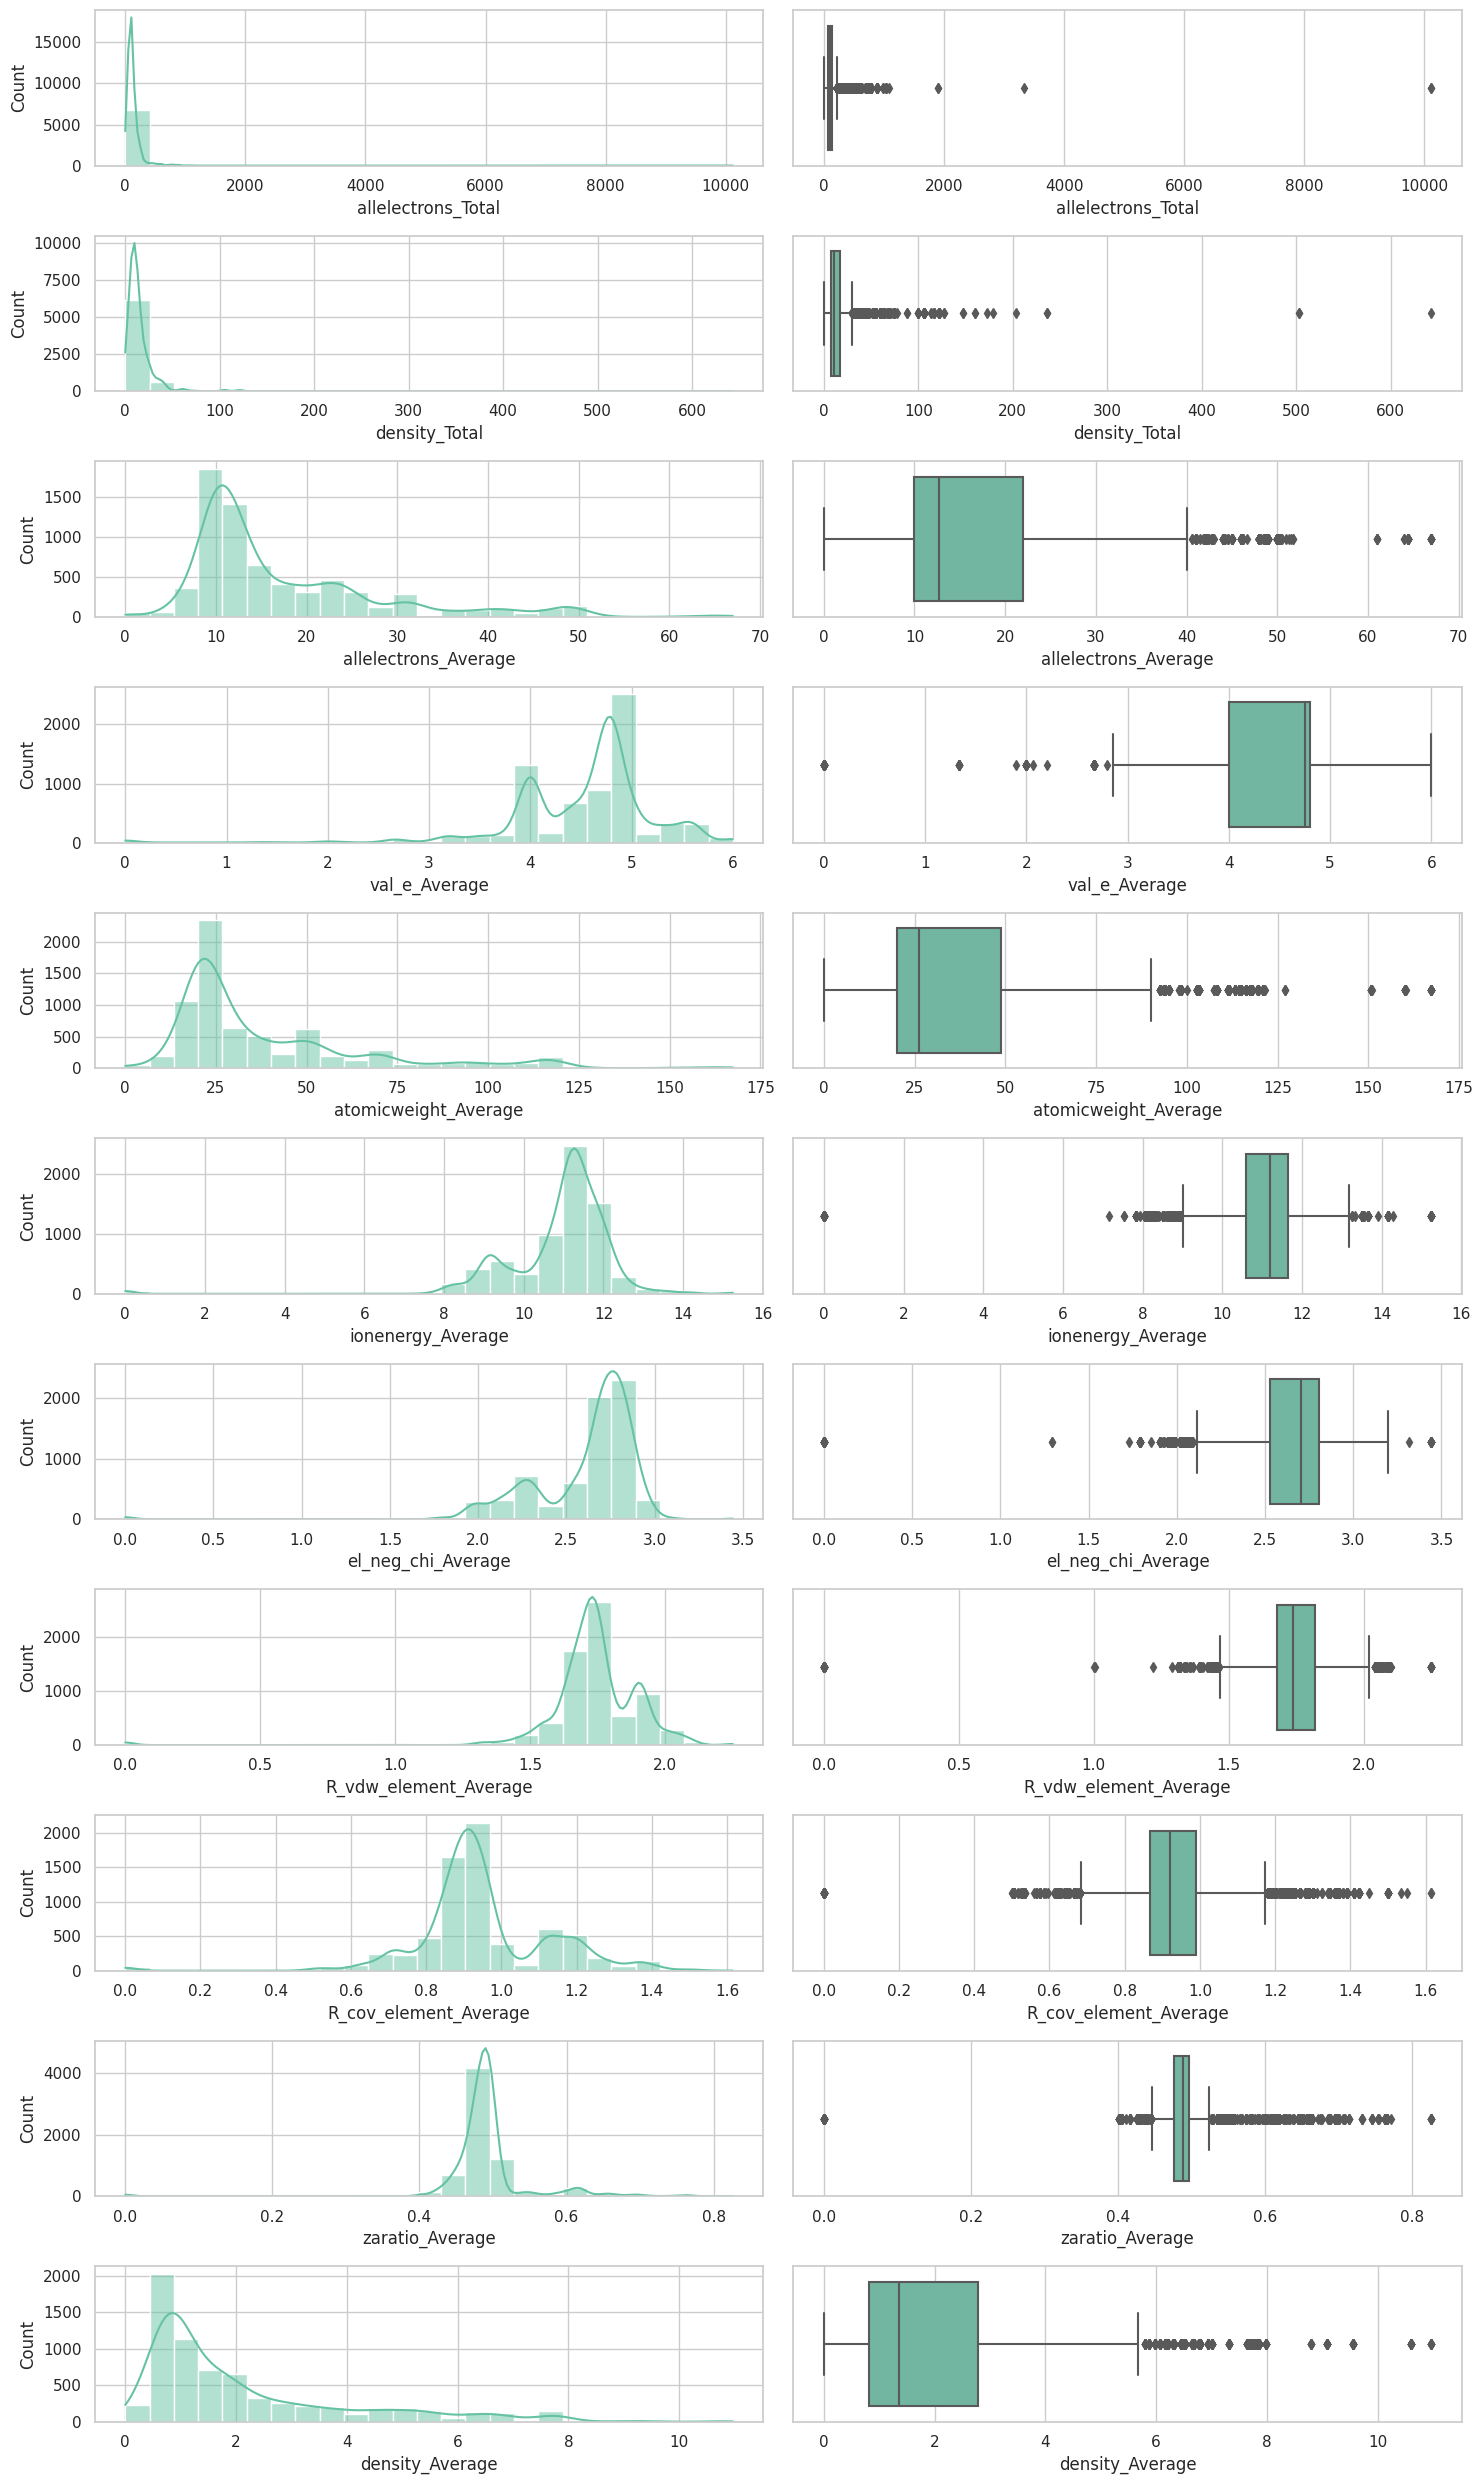

In [6]:
generate_hist_box_plots(test_data)

In [7]:
# Check for null values in playground data
print(f'[Playground Data] Null Values:\n\n{train_data.isnull().sum()}')

[Playground Data] Null Values:

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64


In [8]:
# Check for null values in original data
print(f'[Original Data] Null Values:\n\n{mineral_data.isnull().sum()}')

[Original Data] Null Values:

Hardness                 0
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
dtype: int64


In [9]:
# Check for duplicates
print(f'[Playground Data] Number of duplicates: {train_data.duplicated().sum()}')
print(f'[Mineral Data] Number of duplicates: {mineral_data.duplicated().sum()}')
print(f'[Artificial Crystals Data] Number of duplicates: {artif_cryst.duplicated().sum()}')

[Playground Data] Number of duplicates: 0
[Mineral Data] Number of duplicates: 23
[Artificial Crystals Data] Number of duplicates: 0


In [10]:
# Drop duplicates
mineral_data.drop_duplicates(inplace = True)
print(f'[Mineral Data] Number of duplicates: {mineral_data.duplicated().sum()}')

[Mineral Data] Number of duplicates: 0


In [11]:
# Merge original data and playground data
train_data = pd.concat([train_data, combined_orig])
train_data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [12]:
y=train_data['Hardness'].values
unique_target=np.array([1.25,2.25,3.15,4,5.2,5.75,6.25,7,8.1,9.2])
y_label=[]
for i in range(len(y)):
    min_dis=1
    best_label=0
    for j in range(len(unique_target)):
        dis=abs(y[i]-unique_target[j])
        if dis<min_dis:
            min_dis=dis
            best_label=j
    y_label.append(best_label)
train_data['Hardness_label']=y_label
train_data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness,Hardness_label
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0,5
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5,6
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5,1
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0,5
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0,5


In [13]:
train_data.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness,Hardness_label
count,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000
mean,138.959549,15.299541,16.899964,4.538852,37.195325,10.946574,2.608566,1.727633,0.940013,0.494461,2.119446,4.649026,3.751557
std,300.405217,18.473026,10.444778,0.701123,25.939257,1.435755,0.340576,0.198198,0.182047,0.065793,1.934699,1.683389,1.966943
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.599905,2.530000,1.672500,0.861429,0.476196,0.812440,3.000000,2.000000
50%,100.000000,11.202328,12.571429,4.687500,26.164726,11.220310,2.706000,1.732000,0.914286,0.489272,1.345930,5.500000,5.000000
75%,138.000000,17.590000,21.833333,4.800000,48.719500,11.688350,2.805000,1.797813,0.980000,0.496592,2.732000,6.000000,5.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000,9.000000


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11081 entries, 0 to 51
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     11081 non-null  float64
 1   density_Total          11081 non-null  float64
 2   allelectrons_Average   11081 non-null  float64
 3   val_e_Average          11081 non-null  float64
 4   atomicweight_Average   11081 non-null  float64
 5   ionenergy_Average      11081 non-null  float64
 6   el_neg_chi_Average     11081 non-null  float64
 7   R_vdw_element_Average  11081 non-null  float64
 8   R_cov_element_Average  11081 non-null  float64
 9   zaratio_Average        11081 non-null  float64
 10  density_Average        11081 non-null  float64
 11  Hardness               11081 non-null  float64
 12  Hardness_label         11081 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 1.2 MB


In [15]:
def generate_scatterplots(data, cols, target, s = 10, figsize = (10, 10)):
    fig, ax = plt.subplots(len(cols), 1, figsize = figsize)
    for idx, col in enumerate(cols):
        plt.subplot(len(cols), 1, idx+1)
        sns.scatterplot(data, x = col, y = target, s = s)
    fig.tight_layout()

In [16]:
target = 'Hardness'

## Valence Electrons & Ionization Energy

- Higher valence electrons might influence bonding strength, impacting hardness.
- Higher ionization energy might indicate stronger bonds, potentially contributing to hardness.

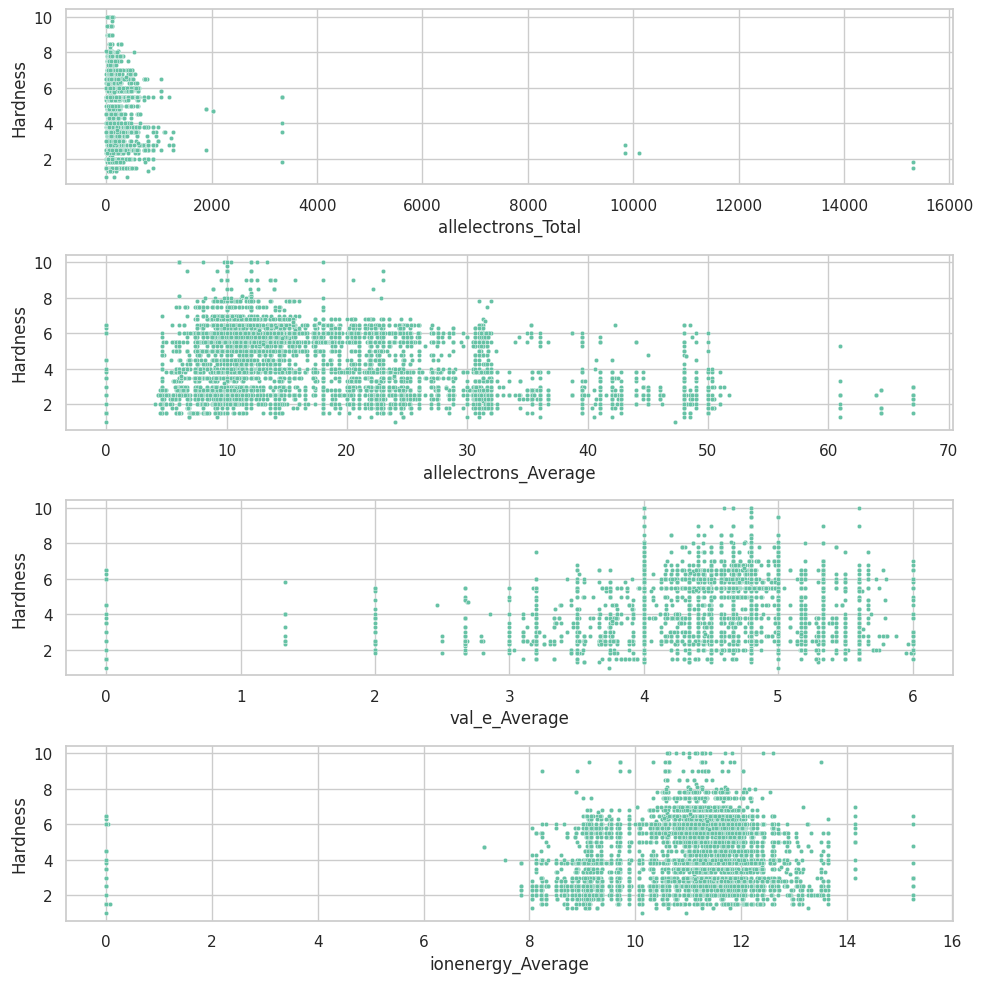

In [17]:
e_cols = ['allelectrons_Total', 'allelectrons_Average', 'val_e_Average', 'ionenergy_Average']
generate_scatterplots(train_data, e_cols, target)

## Physical Properties
- Higher density minerals might have stronger atomic arrangements, correlating with higher hardness.
- Heavier elements might contribute to harder minerals due to greater mass or atomic arrangement.

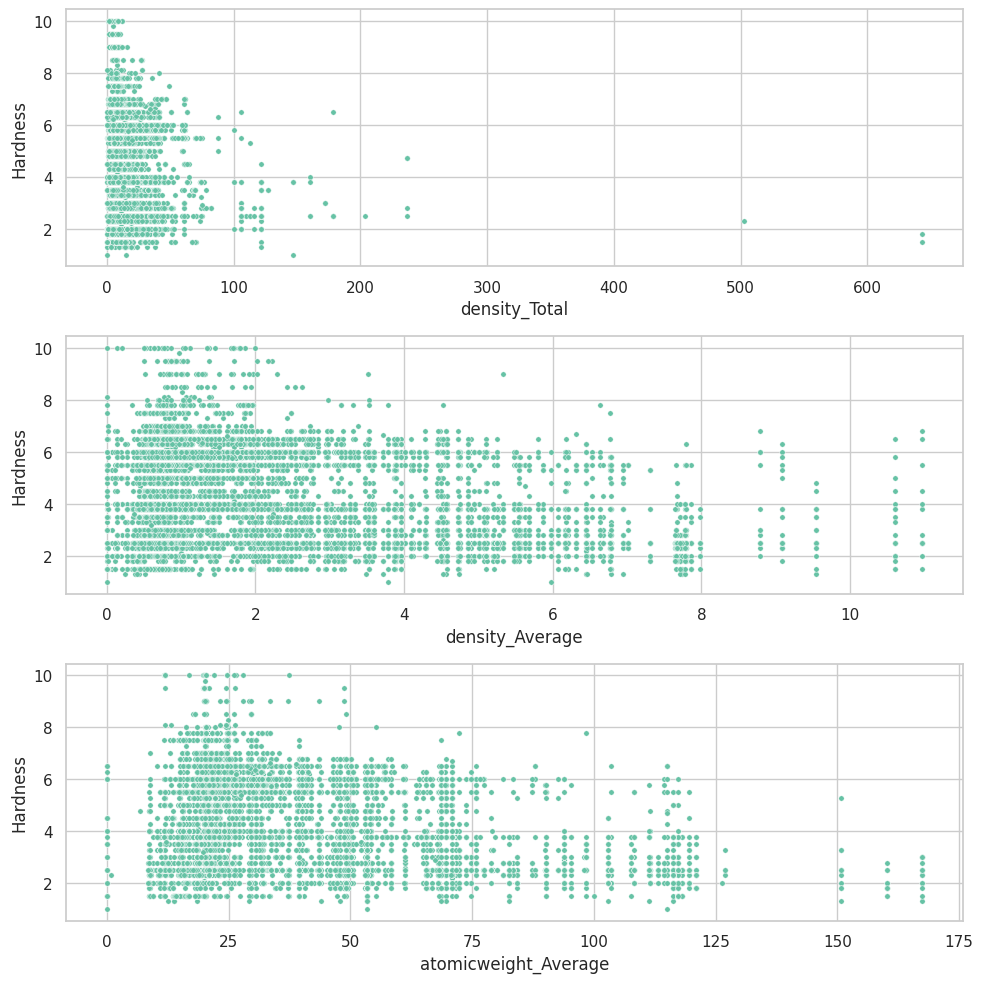

In [18]:
p_cols = ['density_Total', 'density_Average', 'atomicweight_Average']
generate_scatterplots(train_data, p_cols, target, s = 15)

## Chemical Characteristics
- Might influence the type of bonding (ionic or covalent) affecting hardness.
- Smaller atomic radii might suggest closer packing and stronger bonds, affecting hardness.

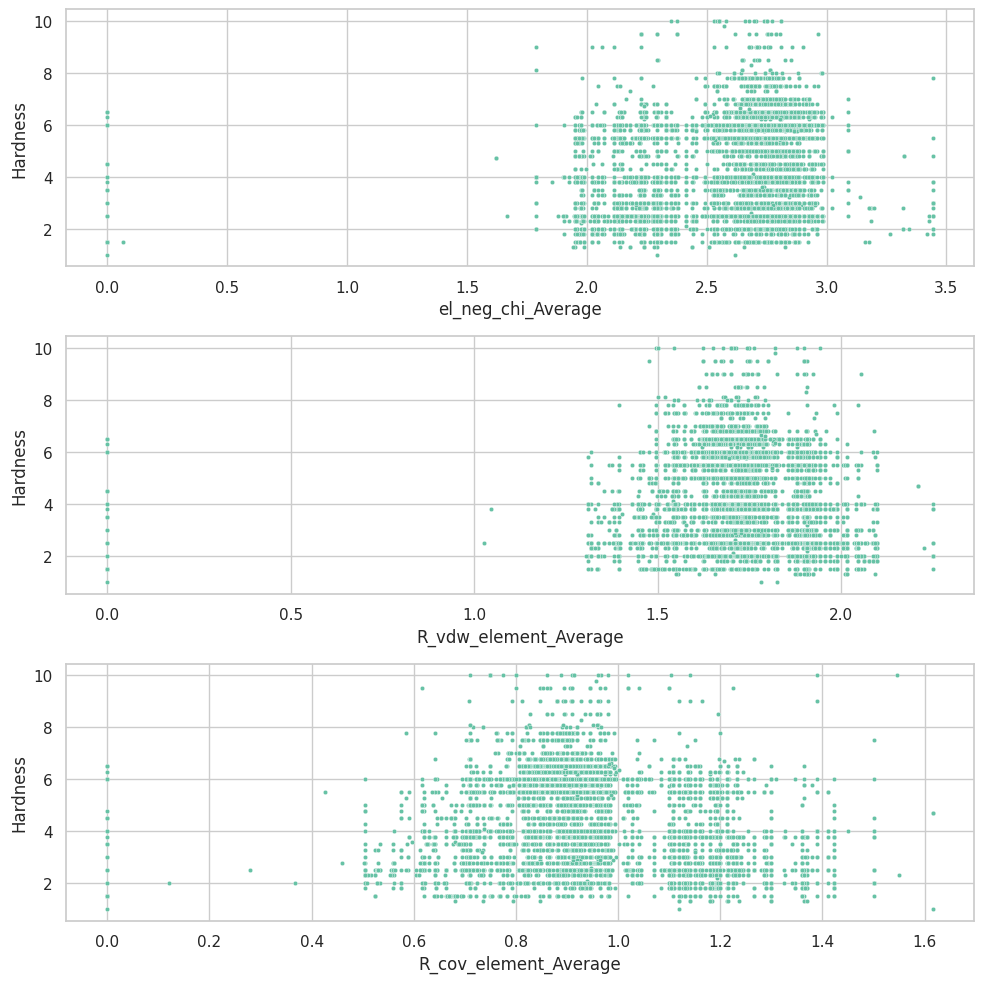

In [19]:
c_cols = ['el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average']
generate_scatterplots(train_data, c_cols, target)

## Ratio Metrics
- The ratio of atomic number to atomic mass might provide insights into the elemental composition's influence on hardness.

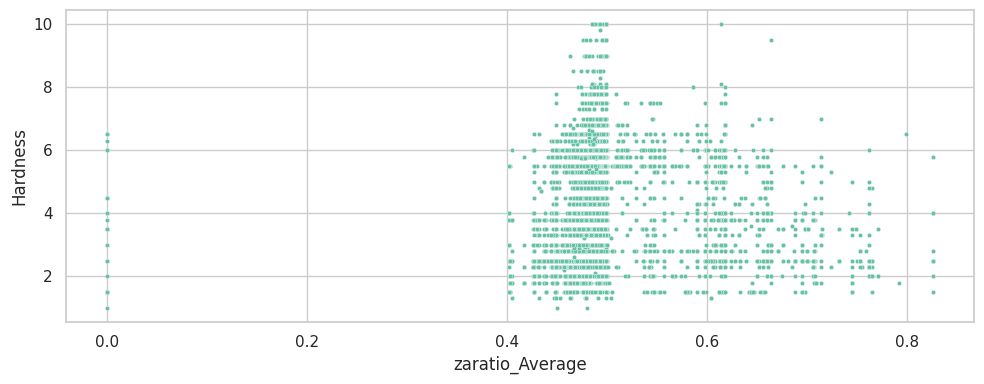

In [20]:
generate_scatterplots(train_data, ['zaratio_Average'], target, figsize = (10, 4))

## Correlations

In [21]:
def correlation_matrices(data_a, data_b, a_label, b_label, figsize = (20, 8), fontsize = 15):
    a_corr, b_corr = data_a.corr(), data_b.corr()
    a_mask, b_mask = np.tril(a_corr), np.tril(b_corr)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = figsize)
    
    sns.heatmap(a_corr, mask = a_mask, annot = True, fmt = '.2f', 
                cmap = 'Greens', linewidths=.5, annot_kws = {'size': 10}, ax = ax[0], cbar = False)
    ax[0].set_title(a_label, fontsize = fontsize)
    
    sns.heatmap(b_corr, mask = b_mask, annot = True, fmt = '.2f', 
                cmap = 'Greens', linewidths=.5, annot_kws = {'size': 10}, ax = ax[1], cbar = False, yticklabels = False)
    ax[1].set_title(b_label, fontsize = fontsize)

    for x in ax:
        x.set_xticklabels(x.get_xticklabels(), rotation = 40, ha = 'right')
    plt.subplots_adjust(top = 1)
    plt.show()

### Train Data vs Test Data Correlation

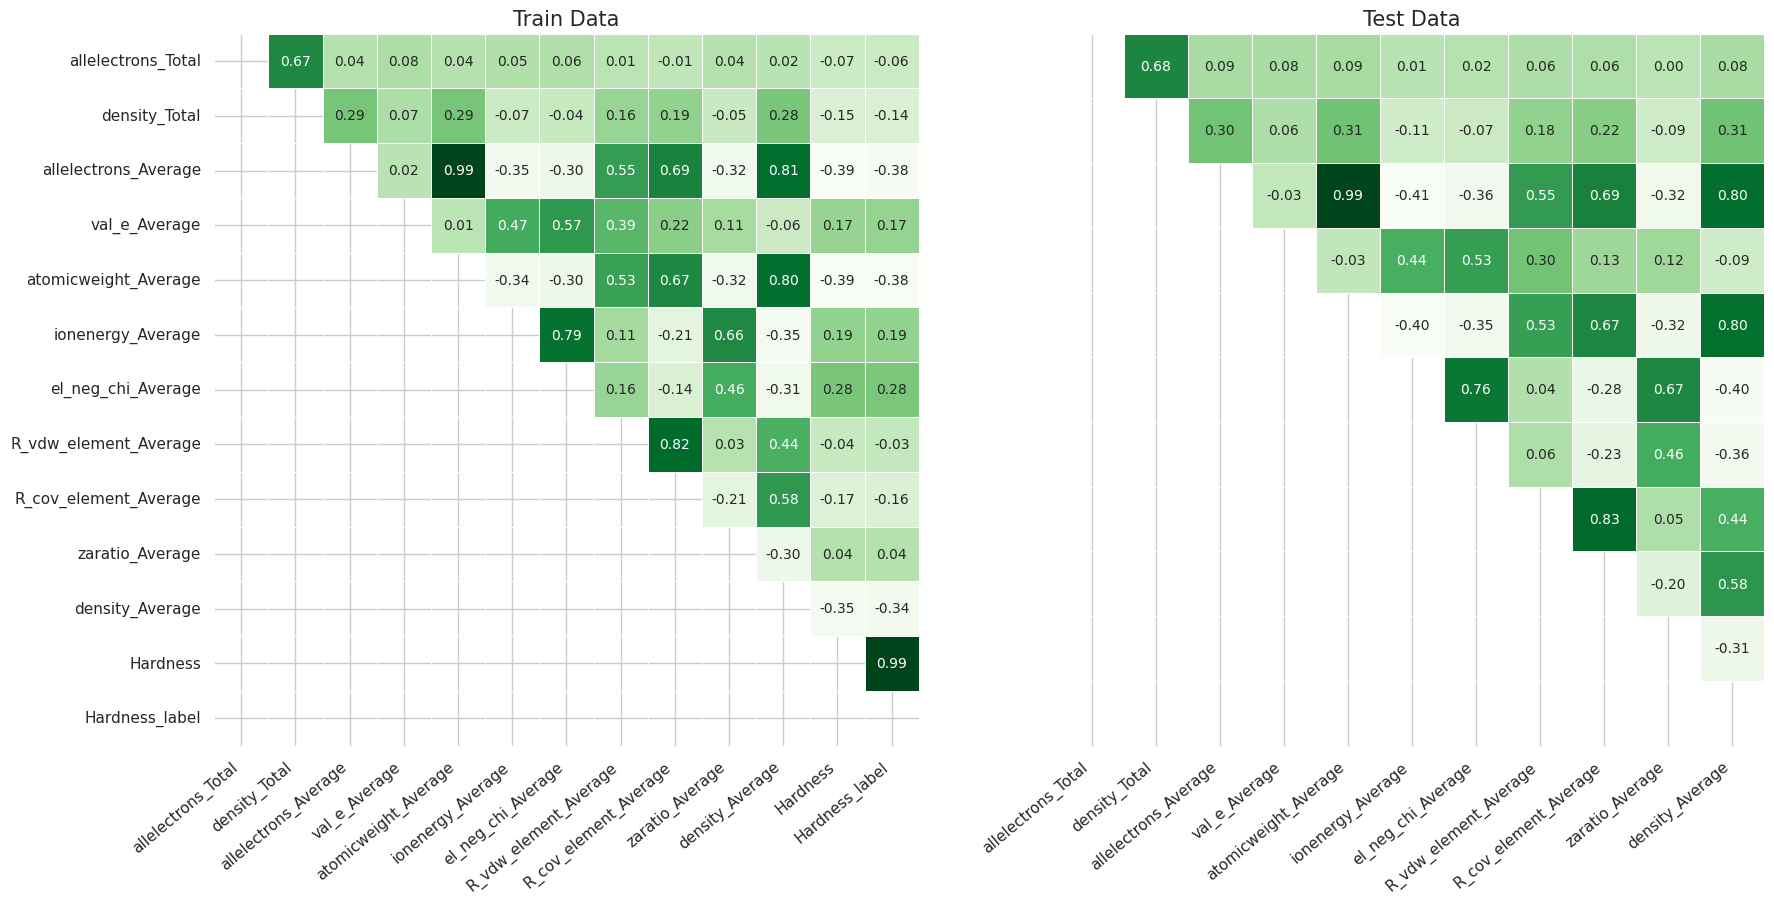

In [22]:
correlation_matrices(train_data, test_data, 'Train Data', 'Test Data')

### Train Data vs Original Data Correlation

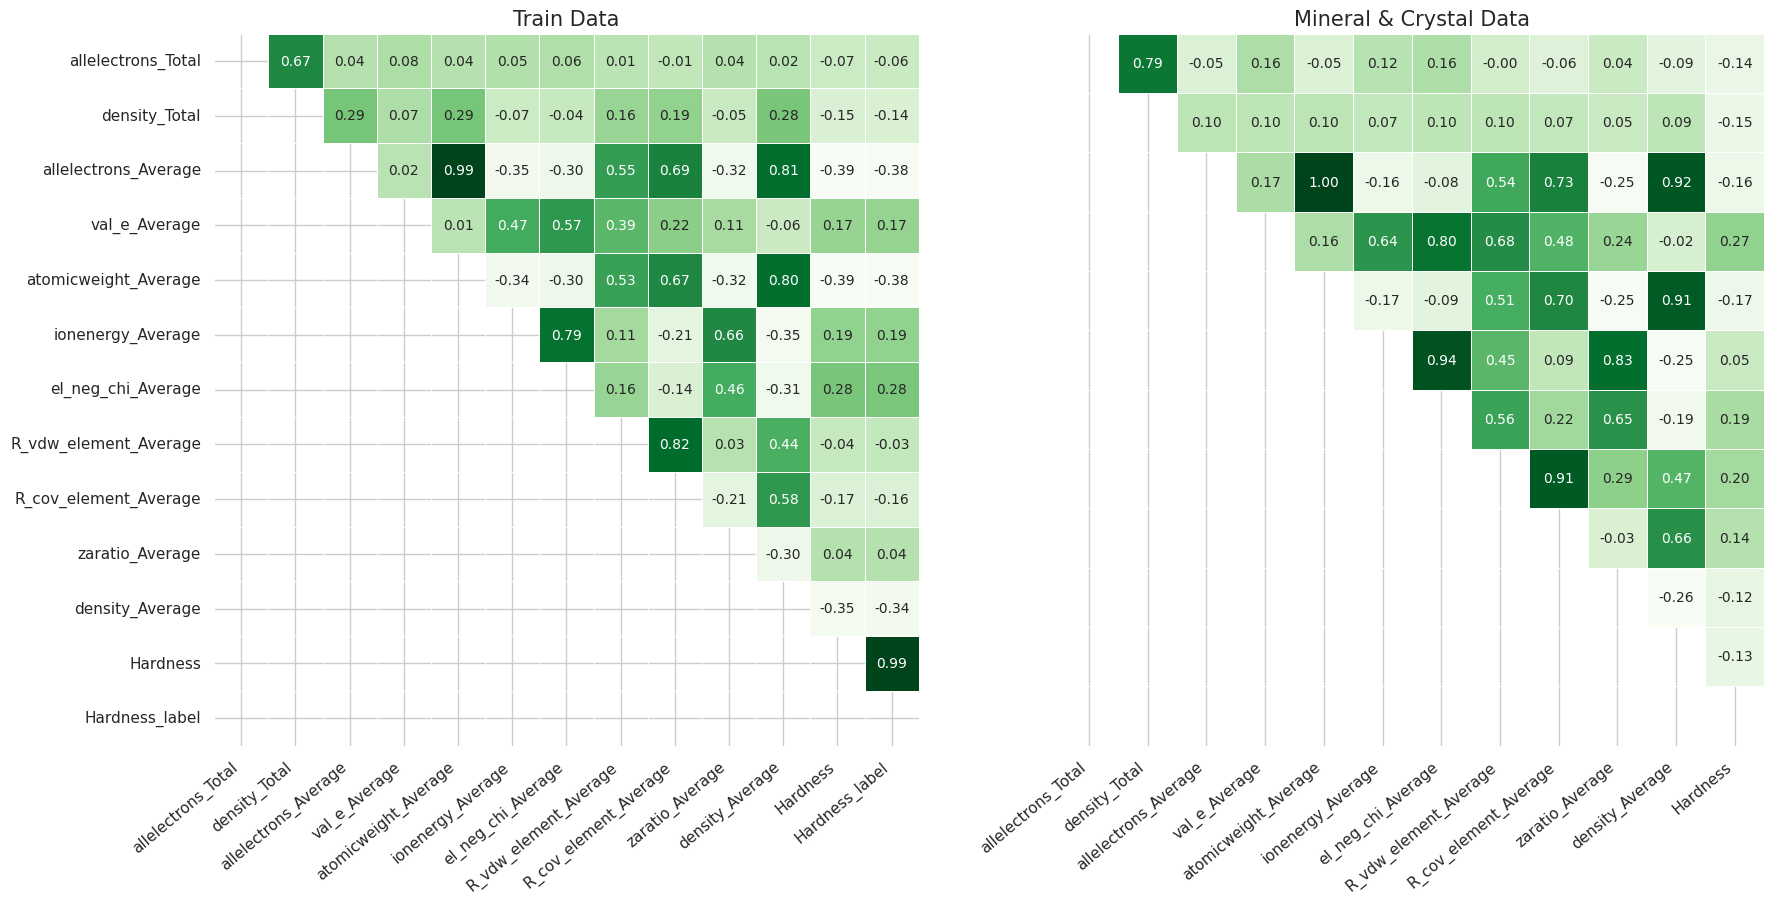

In [23]:
correlation_matrices(train_data, combined_orig, 'Train Data', 'Mineral & Crystal Data')

## Train Correlation Features

<Axes: >

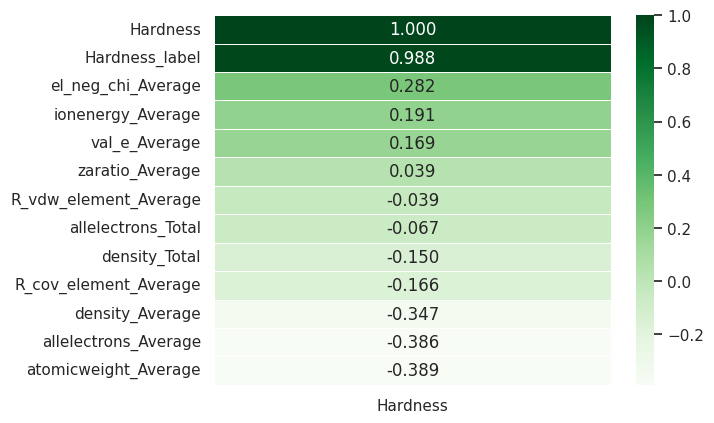

In [24]:
train_corr= train_data.corr()
hardness_corr = train_corr[target].sort_values(ascending = False).to_frame()
sns.heatmap(hardness_corr, annot = True, linewidths = .5, fmt = '.3f', cmap = 'Greens')

## Target Histplot

<Axes: xlabel='Hardness', ylabel='Count'>

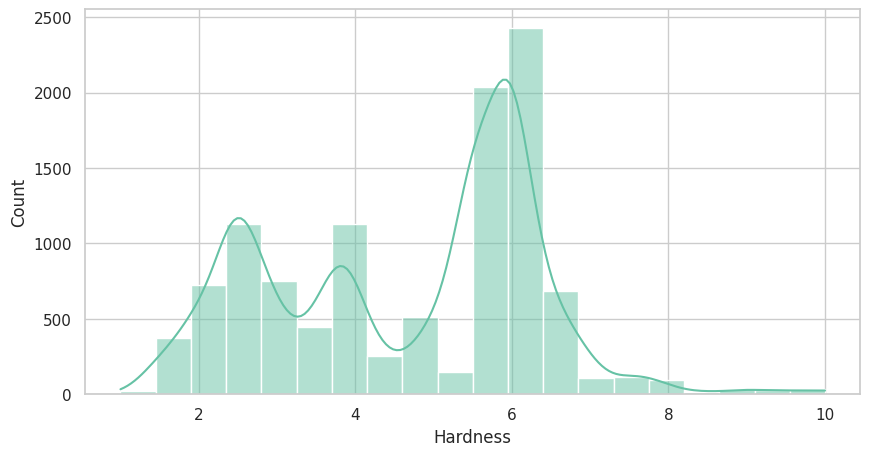

In [25]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(train_data, x = 'Hardness', bins = 20, kde = True)

In [26]:
def skew_transform(data):
    for col in data.columns:
        skewness = data[col].skew()
        if skewness > 0.5:
            print(f'{col} - right skewed')
            data[col] = np.log1p(data[col])
        if skewness < -0.5:
            print(f'{col} - left skewed')
            data[col] = np.square(data[col])
            
skew_transform(train_data)

allelectrons_Total - right skewed
density_Total - right skewed
allelectrons_Average - right skewed
val_e_Average - left skewed
atomicweight_Average - right skewed
ionenergy_Average - left skewed
el_neg_chi_Average - left skewed
R_vdw_element_Average - left skewed
R_cov_element_Average - left skewed
zaratio_Average - left skewed
density_Average - right skewed


In [27]:
train_data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness,Hardness_label
0,4.615121,0.610641,2.397895,23.04,3.073273,122.945962,7.650756,2.999824,0.739600,0.246085,0.649493,6.0,5
1,4.615121,2.146924,2.397895,23.04,3.058655,144.981587,7.590025,2.660161,0.828100,0.242772,0.540928,6.5,6
2,4.343805,2.291119,2.809403,31.36,3.547870,146.078648,7.997584,3.196944,0.746496,0.231821,0.918820,2.5,1
3,4.615121,2.281902,2.397895,23.04,3.054631,119.869652,7.011904,2.643876,0.876096,0.239387,0.581864,6.0,5
4,4.762174,2.358776,2.533697,23.04,3.257640,139.818327,7.650756,2.829124,0.802816,0.242789,1.052502,6.0,5


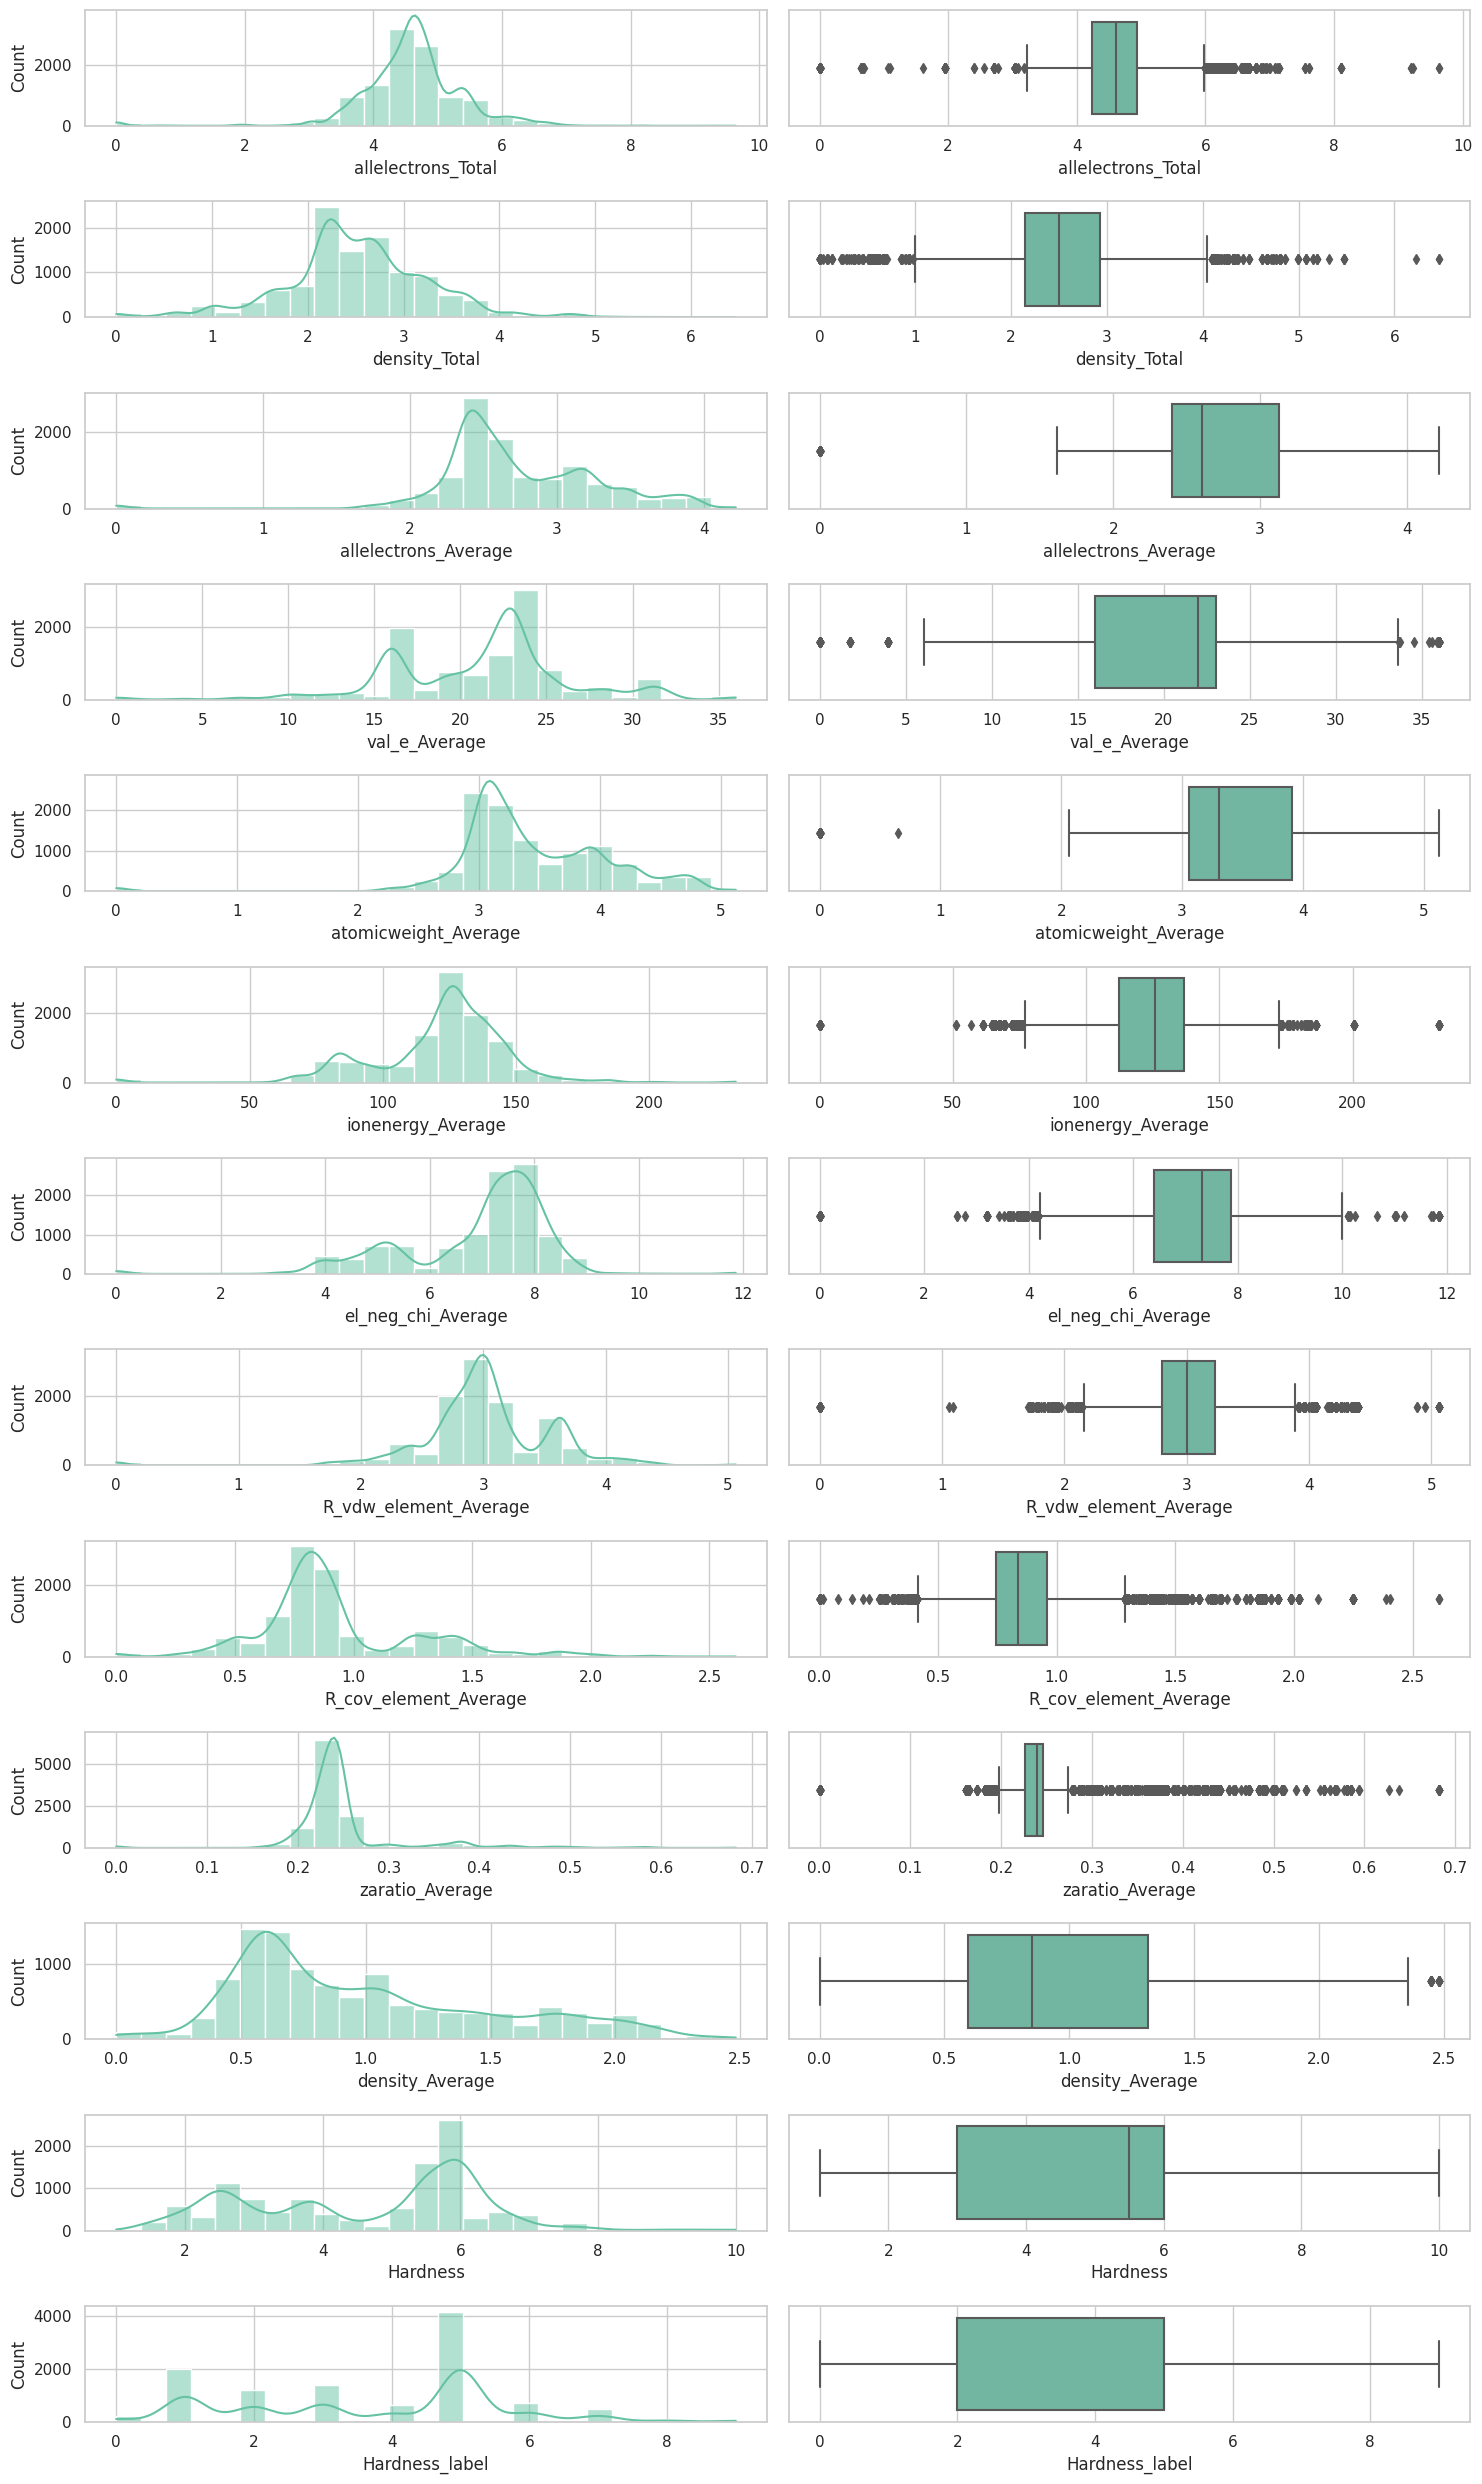

In [28]:
generate_hist_box_plots(train_data)

# 4. Modelling

## Cross-validation with Different Models

In [29]:
random_seed = 42

# Scalers
scaler = StandardScaler()
r_scaler = RobustScaler()
mm_scaler = MinMaxScaler()

X = train_data.drop(['Hardness', 'Hardness_label', 'atomicweight_Average'], axis = 1).reset_index(drop = True)
y = train_data['Hardness']

X.shape, y.shape

((11081, 10), (11081,))

## Optuna Tuning

In [30]:
base_weight = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed)

X_train = r_scaler.fit_transform(X_train)
X_test = r_scaler.transform(X_test)

def hgb_objective(trial):
    params = {
        'loss' : 'absolute_error',
        'learning_rate' : trial.suggest_float('learning_rate', 1e-3, 1),
        'max_iter' : trial.suggest_int('max_iter', 100, 1000), 
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 40),
        'max_depth' : trial.suggest_int('max_depth', 3, 20),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 10, 40),
        'max_bins' : trial.suggest_int('max_bins', 50, 100),
        'random_state' : random_seed
    }
    
    model = HistGradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    
    y_ae = np.abs(y_train - model.predict(X_train))
    lower = np.percentile(y_ae, 10)
    upper = np.percentile(y_ae, 75)
    
    sample_weight = base_weight + ((lower < y_ae) & (y_ae < upper))
    
    model.fit(X_train, y_train, sample_weight = sample_weight)
    
    y_pred = model.predict(X_test)
    
    return median_absolute_error(y_test, y_pred)

def xgb_objective(trial): 
    params = {
        'booster' : 'gbtree',
        'objective' : 'reg:absoluteerror',
        'eta' : trial.suggest_float('eta', 1e-3, 0.1, log=True),
        'max_depth' : trial.suggest_int('max_depth', 6, 20),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight' : trial.suggest_int('min_child_weight', 5, 10),
        'random_state' : random_seed
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    y_ae = np.abs(y_train - model.predict(X_train))
    lower = np.percentile(y_ae, 10)
    upper = np.percentile(y_ae, 75)
    
    sample_weight = base_weight + ((lower < y_ae) & (y_ae < upper))
    
    model.fit(X_train, y_train, sample_weight = sample_weight)
    
    y_pred = model.predict(X_test)
    
    return median_absolute_error(y_test, y_pred)

def lgbm_objective(trial):
    params = {
        'metric': 'mae', 
        'objective' : 'regression',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'max_depth' : trial.suggest_int('max_depth', 5, 20),
        'min_child_weight' : trial.suggest_int('min_child_weight', 5, 10),
        'random_state' : random_seed
    }
    
    model = LGBMRegressor(**params, verbosity = -1)
    model.fit(X_train, y_train)
    
    y_ae = np.abs(y_train - model.predict(X_train))
    lower = np.percentile(y_ae, 10)
    upper = np.percentile(y_ae, 75)
    sample_weight = base_weight + ((lower < y_ae) & (y_ae < upper))
    
    model.fit(X_train, y_train, sample_weight = sample_weight)
    
    y_pred = model.predict(X_test)
    
    return median_absolute_error(y_test, y_pred)

In [31]:
# study = optuna.create_study(direction = 'minimize', pruner=optuna.pruners.HyperbandPruner())
# study.optimize(lgbm_objective, n_trials = 100, timeout = 1000)
# study.best_params, study.best_value

In [32]:
# Best params
hgb_params = {'learning_rate': 0.11772387028507063,
  'max_iter': 998,
  'max_leaf_nodes': 24,
  'max_depth': 10,
  'min_samples_leaf': 18,
  'max_bins': 91}

xgb_params = {'eta': 0.01289753253505924,
  'max_depth': 10,
  'n_estimators': 767,
  'min_child_weight': 10}

lgbm_params = {'n_estimators': 1317,
  'learning_rate': 0.017846415120142317,
  'max_depth': 17,
  'min_child_weight': 6}

In [33]:
base_models = [('HGBRegressor', HistGradientBoostingRegressor(**hgb_params)),
               ('CatBoostRegressor', CatBoostRegressor(verbose = False)),
               ('XGBRegressor', XGBRegressor(**xgb_params)),
               ('LGBMRegressor', LGBMRegressor(**lgbm_params, verbosity = -1)),
               ('RandomForest', RandomForestRegressor())]

metric_fns = [('MedAE', median_absolute_error),
              ('MAE', mean_absolute_error),
              ('MSE', mean_squared_error)]

In [34]:
# Sample weight tuning idea from a discussion by ambrosm: https://www.kaggle.com/competitions/playground-series-s3e25/discussion/455888
# The same base weight, lower and upper bounds were used as per the discussion, will try to further tune these for possibly better results

def calculate_metrics(y_test, y_pred, metric_fns):
    results = {}
    for metric_fn in metric_fns:
        score = metric_fn[1](y_test, y_pred) # calculate metric
        results[metric_fn[0]] = score 
        print(f'{metric_fn[0]}\t:\t{score}')
    return results

def cross_validate(models, 
                   X, y, 
                   n_splits= 10, 
                   shuffle = True, 
                   scaler = None, 
                   metric_fns = None,
                   random_seed = None,
                   transform = None):
    
    base_weight = 0.03
    
    if transform is not None:
        X = X.apply(transform)
    
    if isinstance(X, np.ndarray) == False and isinstance(y, np.ndarray) == False:
        X, y = X.to_numpy(), y.to_numpy()
    
    oof_preds, oof_metrics = {}, {}
    x_data, y_data = [], []
    
    kf = KFold(n_splits= n_splits, shuffle = shuffle, random_state = random_seed)
    for idx, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f'Fold #{idx+1}:')
        print(f'-'*40+'\n')
        
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        x_data.extend(x_test)
        y_data.extend(y_test)
        
        if scaler is not None:
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
        
        for model in models:
            print(f'Cross-validating: [{model[0]}]\n')

            model[1].fit(x_train, y_train)
            
            y_train_ae = np.abs(y_train - model[1].predict(x_train)) # array of absolute errors
            lower = np.percentile(y_train_ae, 10)
            upper = np.percentile(y_train_ae, 75)
            
            print(f'q10: {lower}, q75: {upper}\n')
            
            sample_weight_train = base_weight + ((lower < y_train_ae) & (y_train_ae < upper))
            
            if model[0] not in oof_preds:
                oof_preds[model[0]] = []
                oof_metrics[model[0]] = {}
            
            # Fit model with sample weights
            model[1].fit(x_train, y_train, sample_weight = sample_weight_train)
            
            y_pred = model[1].predict(x_test)
            oof_preds[model[0]].append(y_pred)
            
            for metric_name, result in calculate_metrics(y_test, y_pred, metric_fns).items():
                if metric_name not in oof_metrics[model[0]]:
                    oof_metrics[model[0]][metric_name] = [] 
                oof_metrics[model[0]][metric_name].append(result)
            print('\n')
        
    return oof_preds, oof_metrics, (x_data, y_data)

In [35]:
oof_preds, oof_metrics, data = cross_validate(base_models, X, y, scaler = r_scaler, metric_fns = metric_fns, random_seed = random_seed)

Fold #1:
----------------------------------------

Cross-validating: [HGBRegressor]

q10: 0.04375257142277072, q75: 0.4866469073403882

MedAE	:	0.577335720525352
MAE	:	0.8349710637626584
MSE	:	1.348006136471297


Cross-validating: [CatBoostRegressor]

q10: 0.08648739010788012, q75: 0.9539258520616885

MedAE	:	0.5289228998966067
MAE	:	0.8126296854962102
MSE	:	1.31422863933829


Cross-validating: [XGBRegressor]

q10: 0.05497696399688721, q75: 0.6466816663742065

MedAE	:	0.47231435775756836
MAE	:	0.7923640677260322
MSE	:	1.2996146212876825


Cross-validating: [LGBMRegressor]

q10: 0.07475409317467117, q75: 0.8701206323317705

MedAE	:	0.4850047700753719
MAE	:	0.795541073752871
MSE	:	1.2910187364064794


Cross-validating: [RandomForest]

q10: 0.03000000000000025, q75: 0.47525000000000384

MedAE	:	0.6079999999999988
MAE	:	0.8381965494843364
MSE	:	1.3091708006774812


Fold #2:
----------------------------------------

Cross-validating: [HGBRegressor]

q10: 0.04210360280750702, q75: 0.47684870

In [36]:
# Get out-of-fold metrics 
def get_oof_metrics(metric_dict):
    dict, df = {'models' : []}, pd.DataFrame()
    for model in list(metric_dict.keys()):
        dict['models'].append(model)
        for metric in list(metric_dict[model].keys()):
            if metric not in dict:
                dict[metric] = []
            dict[metric].append(np.mean(metric_dict[model][metric]))
    
    df.index = dict['models']
    for metric in list(dict.keys())[1:]:
        df[metric] = dict[metric]
    
    return df

oof_metrics_df = get_oof_metrics(oof_metrics)
oof_metrics_df.sort_values(by = 'MedAE')

,MedAE,MAE,MSE
XGBRegressor,0.498558,0.838139,1.489167
LGBMRegressor,0.510809,0.837833,1.479681
CatBoostRegressor,0.525852,0.850335,1.488025
HGBRegressor,0.558059,0.862467,1.511388
RandomForest,0.620858,0.880071,1.482309


In [37]:
def aggregate_oof_preds(oof_preds):
    df = pd.DataFrame()
    for key in list(oof_preds.keys()):
        df[key] = np.concatenate(oof_preds[key])
    return df.reset_index(drop = True)

# oof_preds_df = aggregate_oof_preds(oof_preds)

# # Concatenating OOF features and OOF preds into one dataframe
# oof_data_w_preds = pd.concat([pd.DataFrame(data[0], columns = X.columns.tolist()), oof_preds_df[['LGBMRegressor', 'HGBRegressor']]], axis = 1)
# oof_data_w_preds.head()

## Optimizing Weighted Ensemble

In [38]:
class WeightedEnsemble:
    def __init__(self, models, weights = None, random_state = None):
        np.random.seed(random_state)
        self.models = models
        self.weights = np.random.sample(size = (len(models), 1)) if weights is None else np.array(weights).reshape(-1, 1)
        
    def fit(self, X, y, sample_weight = None):
        fitted = []
        for model in self.models:
            if sample_weight is None:
                model.fit(X, y)
            else: 
                model.fit(X, y, sample_weight = sample_weight)
            fitted.append(model)
        self.models = fitted
    
    def predict(self, X):
        preds = np.zeros(shape = (len(self.models), len(X)))
        for idx, model in enumerate(self.models):
            preds[idx] = model.predict(X) * self.weights[idx]
        return np.sum(preds, axis = 0) / np.sum(self.weights)

In [39]:
selected_models = [('HGBRegressor', HistGradientBoostingRegressor(**hgb_params)),
                   ('XGBRegressor', XGBRegressor(**xgb_params)),
                   ('LGBMRegressor', LGBMRegressor(**lgbm_params, verbosity = -1)),
                   ('CatBoostRegressor', CatBoostRegressor(verbose = False))]

In [40]:
# Finding optimal weights for weighted ensemble
def objective(trial):
    base_weight = 0.3
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed)
    
    x_train = r_scaler.fit_transform(x_train)
    x_test = r_scaler.transform(x_test)
    
    weights = [trial.suggest_float(f'w_{i}', 0.1, 0.9) for i in range(len(selected_models))]
    
    model = WeightedEnsemble([model[1] for model in selected_models], weights)
    model.fit(x_train, y_train)
    
    y_train_ae = np.abs(y_train - model.predict(x_train)) # array of absolute errors
    lower = np.percentile(y_train_ae, 10)
    upper = np.percentile(y_train_ae, 75)
    
    sample_weight_train = base_weight + ((lower < y_train_ae) & (y_train_ae < upper))
    
    model.fit(x_train, y_train, sample_weight = sample_weight_train)
    
    y_pred = model.predict(x_test)
    return median_absolute_error(y_test, y_pred)

# we_study = optuna.create_study(direction = 'minimize', pruner=optuna.pruners.HyperbandPruner())
# we_study.optimize(objective, n_trials = 50, timeout = 1000)
# we_study.best_params, we_study.best_value

In [41]:
we_params = {'w_0': 0.7782857016870748,
  'w_1': 0.24813078177206555,
  'w_2': 0.8807813601943523,
  'w_3': 0.24210591598550657}

## Applying Optimized Weights to WeightedEnsemble + Creating StackRegressor and VotingRegressor

In [42]:
we = WeightedEnsemble([model[1] for model in selected_models], [w for w in list(we_params.values())])

stack = StackingRegressor(selected_models, 
                          final_estimator = CatBoostRegressor(verbose = False), 
                          passthrough = True)

vr = VotingRegressor(selected_models)

## Cross-validation with Best Performing Models and Ensembles

In [43]:
top_models = [('CatBoostRegressor', CatBoostRegressor(verbose = False)),
              ('LGBMRegressor', LGBMRegressor(**lgbm_params)),
              ('HGBRegressor', HistGradientBoostingRegressor(**hgb_params)),
              ('XGBRegressor', XGBRegressor(**xgb_params)),
              ('WeightedEnsemble', we),
              ('StackingRegressor', stack), 
              ('VotingRegressor', vr)]

top_oof_preds, top_oof_metrics, top_data = cross_validate(top_models, X, y, metric_fns = metric_fns, scaler = r_scaler, random_seed = random_seed)

Fold #1:
----------------------------------------

Cross-validating: [CatBoostRegressor]

q10: 0.08648739010788012, q75: 0.9539258520616885

MedAE	:	0.5289228998966067
MAE	:	0.8126296854962102
MSE	:	1.31422863933829


Cross-validating: [LGBMRegressor]

q10: 0.07475409317467117, q75: 0.8701206323317705

MedAE	:	0.4850047700753719
MAE	:	0.795541073752871
MSE	:	1.2910187364064794


Cross-validating: [HGBRegressor]

q10: 0.04375257142277072, q75: 0.4866469073403882

MedAE	:	0.577335720525352
MAE	:	0.8349710637626584
MSE	:	1.348006136471297


Cross-validating: [XGBRegressor]

q10: 0.05497696399688721, q75: 0.6466816663742065

MedAE	:	0.47231435775756836
MAE	:	0.7923640677260322
MSE	:	1.2996146212876825


Cross-validating: [WeightedEnsemble]

q10: 0.05855319165912372, q75: 0.6957146986271525

MedAE	:	0.4868243119239368
MAE	:	0.7897587775832117
MSE	:	1.2769269123499476


Cross-validating: [StackingRegressor]

q10: 0.079821251217425, q75: 0.898444328276833

MedAE	:	0.461016084102873
MAE	:	0.79

In [44]:
top_oof_metrics_df = get_oof_metrics(top_oof_metrics)
top_oof_metrics_df.sort_values(by = 'MedAE')

,MedAE,MAE,MSE
StackingRegressor,0.482212,0.832214,1.511903
XGBRegressor,0.498558,0.838139,1.489167
VotingRegressor,0.505172,0.830894,1.458841
WeightedEnsemble,0.507043,0.832844,1.463518
LGBMRegressor,0.510809,0.837833,1.479681
CatBoostRegressor,0.525852,0.850335,1.488025
HGBRegressor,0.558059,0.862467,1.511388


## Creaing Meta Dataset with OOF Predictions

In [45]:
top_oof_preds_df = aggregate_oof_preds(top_oof_preds)
top_oof_data_w_preds = pd.concat([pd.DataFrame(top_data[0], columns = X.columns.tolist()), 
                                  top_oof_preds_df[['VotingRegressor', 'StackingRegressor', 'WeightedEnsemble', 'LGBMRegressor']]], axis = 1)
top_oof_data_w_preds.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,VotingRegressor,StackingRegressor,WeightedEnsemble,LGBMRegressor
0,4.615121,2.281902,2.397895,23.04,119.869652,7.011904,2.643876,0.876096,0.239387,0.581864,6.008041,5.834781,6.063022,6.072278
1,4.663439,1.825194,2.397895,23.04,131.452187,7.573504,3.196944,0.894916,0.231821,0.594674,5.399193,5.430746,5.279820,5.328624
2,4.418841,3.014652,3.468856,23.04,93.303236,4.080400,3.625216,1.401856,0.201507,2.033398,3.343267,3.195410,3.418837,3.556114
3,3.850148,2.096094,2.533697,23.04,123.586800,7.817616,2.896804,0.739600,0.242789,1.082940,5.593151,5.856196,5.633430,5.566168
4,4.976734,2.806386,3.891820,16.00,108.134002,5.017600,4.060225,1.392400,0.201507,2.171907,2.732109,2.537431,2.875985,2.627704


## Creating a Neural Network with Pytorch Lightning + Custom Metrics for MedAE and RAE

In [46]:
# Creating Neural Network meta model with Pytorch Lightning
class MedianAbsoluteError(Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.add_state('abs_errors', default = torch.tensor([]), dist_reduce_fx = 'cat')
    
    def update(self, preds, target):
        errors = torch.abs(preds - target)
        self.abs_errors = torch.cat([self.abs_errors, errors])
        
    def compute(self):
        return torch.median(self.abs_errors)
    
class RangeAbsoluteError(Metric):
    def __init__(self):
        super().__init__()
        self.add_state('abs_errors', default = [], dist_reduce_fx = 'cat')
        
    def update(self, y_pred, y_true):
        abs_errors = torch.abs(y_pred - y_true)
        self.abs_errors.append(abs_errors)
    
    def compute(self):
        if len(self.abs_errors) == 0:
            return torch.tensor(0.0)
        
        all_errors = torch.cat(self.abs_errors)
        return torch.max(all_errors) - torch.min(all_errors)
            
class LightNN(pl.LightningModule):
    def __init__(self, in_shape, out_shape, loss_fn = None, metric = None, hidden_units:list = None):
        super().__init__()
        
        hidden_units.insert(0, in_shape)
        layers = [(nn.Linear(hidden_units[idx-1], hidden_units[idx]), nn.GELU()) for idx in range(1, len(hidden_units))]
        layers = [item for layer in layers for item in layer]
        
        self.epoch_count = 0
        
        self.metric = metric
        self.loss_fn = loss_fn
        
        self.metric_step_scores = {'train': [],
                                   'valid': [],
                                   'test' : []}
        self.step_losses = {'train': [], 
                            'valid': [], 
                            'test' : []}
        
        self.metric_epoch_scores = {'train' : [],
                                    'valid' : []}
        self.epoch_losses = {'train' : [],
                             'valid' : []}
        
        # Layers
        self.bn = nn.BatchNorm1d(in_shape)
        self.linear_stack = nn.Sequential(*layers)
        self.linear_out = nn.Linear(hidden_units[-1], 1)
    
    def forward(self, x):
        x = self.bn(x)
        x = self.linear_stack(x)
        x = self.linear_out(x)
        return x
    
    def training_step(self, batch, batch_idx):
        loss, rae = self._common_step(batch, batch_idx)
        
        self.metric_step_scores['train'].append(rae)
        self.step_losses['train'].append(loss)
        
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        loss, rae = self._common_step(batch, batch_idx)
        
        self.metric_step_scores['valid'].append(rae)
        self.step_losses['valid'].append(loss)
        
        self.log('val_loss', loss)
        
        return loss
    
    def test_step(self, batch,batch_idx):
        loss, rae = self._common_step(batch, batch_idx)
        
        self.metric_step_scores['test'].append(rae)
        self.step_losses['test'].append(loss)
        
        self.log('test_loss', loss)
        
        return loss
    
    def _common_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.forward(x).flatten()
        
        loss = self.loss_fn(y_pred, y)
        medae = self.metric(y_pred, y)
        
        return loss, medae
    
    def on_train_epoch_end(self):
        avg_train_rae = torch.mean(torch.tensor(self.metric_step_scores['train']))
        avg_train_loss = torch.mean(torch.tensor(self.step_losses['train']))
        
        avg_valid_rae = torch.mean(torch.tensor(self.metric_step_scores['valid']))
        avg_valid_loss = torch.mean(torch.tensor(self.step_losses['valid']))
        
        self.metric_epoch_scores['train'].append(avg_train_rae)
        self.metric_epoch_scores['valid'].append(avg_valid_rae)
        
        self.epoch_losses['train'].append(avg_train_loss)
        self.epoch_losses['valid'].append(avg_valid_loss)

        self.epoch_count+=1
        
        print(f'Epoch #{self.epoch_count}')
        print('-'*40+'\n')
        print(f'Train -- RAE: {avg_train_rae:.4f}, Loss: {avg_train_loss:.4f}')
        print(f'Valid -- RAE: {avg_valid_rae:.4f}, Loss: {avg_valid_loss:.4f}\n')
        
        self.metric_step_scores = {'train': [],
                              'valid': [],
                              'test' : []}
        self.step_losses = {'train': [], 
                       'valid': [], 
                       'test' : []}
        
    def on_test_epoch_end(self):
        avg_test_rae = torch.mean(torch.tensor(self.metric_step_scores['test']))
        avg_test_loss = torch.mean(torch.tensor(self.step_losses['test']))
        
        print(f'Test  -- RAE: {avg_test_rae:.4f}, Loss: {avg_test_loss:.4f}\n')
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = 1e-3)
        reduce_lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.8, 
                                                                          patience = 3, min_lr = 1e-5, verbose = True)
        lr_monitor = LearningRateMonitor(logging_interval = 'epoch')
        
        return {
            'optimizer': optimizer, 
            'lr_scheduler': {
                'scheduler': reduce_lr_on_plateau,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }

## Creating Dataloaders for Neural Network

In [47]:
torch.manual_seed(random_seed)
BATCH_SIZE = 32

# Create custom dataset 
class MohsHardness(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.targets = torch.tensor(targets, dtype = torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        target = self.targets[index]        
        return sample, target 
    
# Split OOF data into train, validation, and test splits
X_train, X_test, y_train, y_test = train_test_split(top_oof_data_w_preds.to_numpy(), np.array(top_data[1]), test_size = 0.2, random_state = random_seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = random_seed)

X_train = r_scaler.fit_transform(X_train)
X_valid = r_scaler.transform(X_valid)
X_test = r_scaler.transform(X_test)

oof_train = MohsHardness(X_train, y_train)
oof_valid = MohsHardness(X_valid, y_valid)
oof_test = MohsHardness(X_test, y_test)

oof_train_dataloader = DataLoader(oof_train, batch_size = BATCH_SIZE, shuffle = True, num_workers = 3)
oof_valid_dataloader = DataLoader(oof_valid, batch_size = BATCH_SIZE, shuffle = True, num_workers = 3)
oof_test_dataloader = DataLoader(oof_test, batch_size = BATCH_SIZE, shuffle = False, num_workers = 3)

In [48]:
# Custom metrics
MedAE = MedianAbsoluteError()
RAE = RangeAbsoluteError()

lnn = LightNN(in_shape = X_train[0].shape[0], 
              out_shape = 1,
              hidden_units = [16, 32],
              metric = RAE, 
              loss_fn = MedAE)
lnn

LightNN(
  (metric): RangeAbsoluteError()
  (loss_fn): MedianAbsoluteError()
  (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_stack): Sequential(
    (0): Linear(in_features=14, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): GELU(approximate='none')
  )
  (linear_out): Linear(in_features=32, out_features=1, bias=True)
)

In [49]:
es = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = True, mode = 'min')
mc = ModelCheckpoint(save_top_k = 1, monitor = 'val_loss', mode = 'min')

trainer = pl.Trainer(min_epochs = 1, 
                     max_epochs = 100, 
                     enable_progress_bar = True, 
                     callbacks = [es, mc], )
trainer.fit(lnn, oof_train_dataloader, oof_valid_dataloader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #1
----------------------------------------

Train -- RAE: 5.0423, Loss: 2.5546
Valid -- RAE: 4.1178, Loss: 1.0983



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #2
----------------------------------------

Train -- RAE: 3.8572, Loss: 0.7707
Valid -- RAE: 3.7527, Loss: 0.7253



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #3
----------------------------------------

Train -- RAE: 3.7983, Loss: 0.6972
Valid -- RAE: 3.4612, Loss: 0.6211



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #4
----------------------------------------

Train -- RAE: 3.6728, Loss: 0.6509
Valid -- RAE: 3.4240, Loss: 0.5649



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #5
----------------------------------------

Train -- RAE: 3.6399, Loss: 0.6266
Valid -- RAE: 3.6926, Loss: 0.4847



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #6
----------------------------------------

Train -- RAE: 3.6707, Loss: 0.5984
Valid -- RAE: 3.3547, Loss: 0.5364



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #7
----------------------------------------

Train -- RAE: 3.5891, Loss: 0.6035
Valid -- RAE: 3.5310, Loss: 0.5140



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #8
----------------------------------------

Train -- RAE: 3.5774, Loss: 0.5592
Valid -- RAE: 3.4770, Loss: 0.4896



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #9
----------------------------------------

Train -- RAE: 3.5260, Loss: 0.5475
Valid -- RAE: 3.4125, Loss: 0.4723



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #10
----------------------------------------

Train -- RAE: 3.4913, Loss: 0.5461
Valid -- RAE: 3.2678, Loss: 0.5065



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #11
----------------------------------------

Train -- RAE: 3.4858, Loss: 0.5402
Valid -- RAE: 3.3350, Loss: 0.4779



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #12
----------------------------------------

Train -- RAE: 3.4948, Loss: 0.5338
Valid -- RAE: 3.5025, Loss: 0.5432



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #13
----------------------------------------

Train -- RAE: 3.5171, Loss: 0.5297
Valid -- RAE: 3.5969, Loss: 0.4598



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #14
----------------------------------------

Train -- RAE: 3.4969, Loss: 0.5163
Valid -- RAE: 3.3668, Loss: 0.4548



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #15
----------------------------------------

Train -- RAE: 3.5171, Loss: 0.5073
Valid -- RAE: 3.4442, Loss: 0.4440



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #16
----------------------------------------

Train -- RAE: 3.5435, Loss: 0.4908
Valid -- RAE: 3.4399, Loss: 0.4665



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #17
----------------------------------------

Train -- RAE: 3.5210, Loss: 0.4947
Valid -- RAE: 3.4965, Loss: 0.4542



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #18
----------------------------------------

Train -- RAE: 3.5910, Loss: 0.4990
Valid -- RAE: 3.4539, Loss: 0.4743



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #19
----------------------------------------

Train -- RAE: 3.5590, Loss: 0.4987
Valid -- RAE: 3.5441, Loss: 0.4529

Epoch 00019: reducing learning rate of group 0 to 8.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #20
----------------------------------------

Train -- RAE: 3.5535, Loss: 0.4860
Valid -- RAE: 3.4296, Loss: 0.4684



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #21
----------------------------------------

Train -- RAE: 3.5305, Loss: 0.4784
Valid -- RAE: 3.6184, Loss: 0.4439



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #22
----------------------------------------

Train -- RAE: 3.6101, Loss: 0.4786
Valid -- RAE: 3.4162, Loss: 0.4542



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #23
----------------------------------------

Train -- RAE: 3.6080, Loss: 0.4792
Valid -- RAE: 3.3600, Loss: 0.4888

Epoch 00023: reducing learning rate of group 0 to 6.4000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #24
----------------------------------------

Train -- RAE: 3.5655, Loss: 0.4707
Valid -- RAE: 3.4733, Loss: 0.4266



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #25
----------------------------------------

Train -- RAE: 3.6138, Loss: 0.4745
Valid -- RAE: 3.5201, Loss: 0.4440



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #26
----------------------------------------

Train -- RAE: 3.5853, Loss: 0.4644
Valid -- RAE: 3.5150, Loss: 0.4177



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #27
----------------------------------------

Train -- RAE: 3.6246, Loss: 0.4691
Valid -- RAE: 3.4612, Loss: 0.4205



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #28
----------------------------------------

Train -- RAE: 3.5971, Loss: 0.4789
Valid -- RAE: 3.4482, Loss: 0.4292



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #29
----------------------------------------

Train -- RAE: 3.6129, Loss: 0.4536
Valid -- RAE: 3.5028, Loss: 0.4174



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #30
----------------------------------------

Train -- RAE: 3.5589, Loss: 0.4629
Valid -- RAE: 3.4114, Loss: 0.4407

Epoch 00030: reducing learning rate of group 0 to 5.1200e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #31
----------------------------------------

Train -- RAE: 3.6163, Loss: 0.4605
Valid -- RAE: 3.5589, Loss: 0.4102



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #32
----------------------------------------

Train -- RAE: 3.6143, Loss: 0.4573
Valid -- RAE: 3.5667, Loss: 0.4237



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #33
----------------------------------------

Train -- RAE: 3.6122, Loss: 0.4589
Valid -- RAE: 3.5555, Loss: 0.4111



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #34
----------------------------------------

Train -- RAE: 3.6145, Loss: 0.4687
Valid -- RAE: 3.5021, Loss: 0.4284



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #35
----------------------------------------

Train -- RAE: 3.6242, Loss: 0.4673
Valid -- RAE: 3.5402, Loss: 0.4342

Epoch 00035: reducing learning rate of group 0 to 4.0960e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #36
----------------------------------------

Train -- RAE: 3.6422, Loss: 0.4518
Valid -- RAE: 3.4516, Loss: 0.3969



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #37
----------------------------------------

Train -- RAE: 3.5830, Loss: 0.4560
Valid -- RAE: 3.5591, Loss: 0.4452



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #38
----------------------------------------

Train -- RAE: 3.5897, Loss: 0.4552
Valid -- RAE: 3.4074, Loss: 0.4215



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #39
----------------------------------------

Train -- RAE: 3.6017, Loss: 0.4658
Valid -- RAE: 3.5341, Loss: 0.4150



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #40
----------------------------------------

Train -- RAE: 3.6300, Loss: 0.4554
Valid -- RAE: 3.4899, Loss: 0.4112

Epoch 00040: reducing learning rate of group 0 to 3.2768e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #41
----------------------------------------

Train -- RAE: 3.6053, Loss: 0.4513
Valid -- RAE: 3.5625, Loss: 0.4204



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #42
----------------------------------------

Train -- RAE: 3.6176, Loss: 0.4475
Valid -- RAE: 3.4098, Loss: 0.4315



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #43
----------------------------------------

Train -- RAE: 3.6482, Loss: 0.4630
Valid -- RAE: 3.5805, Loss: 0.4310



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #44
----------------------------------------

Train -- RAE: 3.6409, Loss: 0.4480
Valid -- RAE: 3.5459, Loss: 0.4238

Epoch 00044: reducing learning rate of group 0 to 2.6214e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #45
----------------------------------------

Train -- RAE: 3.5882, Loss: 0.4422
Valid -- RAE: 3.5094, Loss: 0.4330



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #46
----------------------------------------

Train -- RAE: 3.6448, Loss: 0.4546
Valid -- RAE: 3.3806, Loss: 0.3919



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #47
----------------------------------------

Train -- RAE: 3.6032, Loss: 0.4489
Valid -- RAE: 3.4801, Loss: 0.4195



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #48
----------------------------------------

Train -- RAE: 3.6357, Loss: 0.4469
Valid -- RAE: 3.4030, Loss: 0.3962



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #49
----------------------------------------

Train -- RAE: 3.6055, Loss: 0.4470
Valid -- RAE: 3.5152, Loss: 0.4296



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #50
----------------------------------------

Train -- RAE: 3.6233, Loss: 0.4502
Valid -- RAE: 3.4305, Loss: 0.4328

Epoch 00050: reducing learning rate of group 0 to 2.0972e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #51
----------------------------------------

Train -- RAE: 3.6301, Loss: 0.4520
Valid -- RAE: 3.4911, Loss: 0.4003



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #52
----------------------------------------

Train -- RAE: 3.6120, Loss: 0.4496
Valid -- RAE: 3.5965, Loss: 0.4428



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #53
----------------------------------------

Train -- RAE: 3.6576, Loss: 0.4580
Valid -- RAE: 3.5159, Loss: 0.4379



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #54
----------------------------------------

Train -- RAE: 3.6356, Loss: 0.4453
Valid -- RAE: 3.5611, Loss: 0.4195

Epoch 00054: reducing learning rate of group 0 to 1.6777e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #55
----------------------------------------

Train -- RAE: 3.6383, Loss: 0.4434
Valid -- RAE: 3.5156, Loss: 0.3955



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #56
----------------------------------------

Train -- RAE: 3.5931, Loss: 0.4567
Valid -- RAE: 3.5469, Loss: 0.3997



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #57
----------------------------------------

Train -- RAE: 3.6138, Loss: 0.4465
Valid -- RAE: 3.3819, Loss: 0.4412



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #58
----------------------------------------

Train -- RAE: 3.5896, Loss: 0.4451
Valid -- RAE: 3.4997, Loss: 0.4208

Epoch 00058: reducing learning rate of group 0 to 1.3422e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #59
----------------------------------------

Train -- RAE: 3.5981, Loss: 0.4440
Valid -- RAE: 3.5614, Loss: 0.4005



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #60
----------------------------------------

Train -- RAE: 3.6171, Loss: 0.4492
Valid -- RAE: 3.4848, Loss: 0.4140



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #61
----------------------------------------

Train -- RAE: 3.5909, Loss: 0.4422
Valid -- RAE: 3.5866, Loss: 0.3985



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #62
----------------------------------------

Train -- RAE: 3.6512, Loss: 0.4506
Valid -- RAE: 3.4728, Loss: 0.4132

Epoch 00062: reducing learning rate of group 0 to 1.0737e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #63
----------------------------------------

Train -- RAE: 3.6360, Loss: 0.4435
Valid -- RAE: 3.3884, Loss: 0.3892



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #64
----------------------------------------

Train -- RAE: 3.6637, Loss: 0.4527
Valid -- RAE: 3.5316, Loss: 0.4235



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #65
----------------------------------------

Train -- RAE: 3.6238, Loss: 0.4503
Valid -- RAE: 3.4329, Loss: 0.4045



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #66
----------------------------------------

Train -- RAE: 3.6518, Loss: 0.4331
Valid -- RAE: 3.5681, Loss: 0.4160



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #67
----------------------------------------

Train -- RAE: 3.6435, Loss: 0.4443
Valid -- RAE: 3.5406, Loss: 0.4010

Epoch 00067: reducing learning rate of group 0 to 8.5899e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #68
----------------------------------------

Train -- RAE: 3.6290, Loss: 0.4331
Valid -- RAE: 3.4757, Loss: 0.4001



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #69
----------------------------------------

Train -- RAE: 3.6112, Loss: 0.4276
Valid -- RAE: 3.4176, Loss: 0.4400



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #70
----------------------------------------

Train -- RAE: 3.5946, Loss: 0.4488
Valid -- RAE: 3.5006, Loss: 0.4251



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #71
----------------------------------------

Train -- RAE: 3.6032, Loss: 0.4484
Valid -- RAE: 3.4749, Loss: 0.4069

Epoch 00071: reducing learning rate of group 0 to 6.8719e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #72
----------------------------------------

Train -- RAE: 3.6309, Loss: 0.4482
Valid -- RAE: 3.3856, Loss: 0.4180



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #73
----------------------------------------

Train -- RAE: 3.5996, Loss: 0.4449
Valid -- RAE: 3.5016, Loss: 0.4238



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #74
----------------------------------------

Train -- RAE: 3.6351, Loss: 0.4352
Valid -- RAE: 3.4567, Loss: 0.4213



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #75
----------------------------------------

Train -- RAE: 3.6250, Loss: 0.4393
Valid -- RAE: 3.5011, Loss: 0.4225

Epoch 00075: reducing learning rate of group 0 to 5.4976e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #76
----------------------------------------

Train -- RAE: 3.6083, Loss: 0.4424
Valid -- RAE: 3.4774, Loss: 0.4245



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #77
----------------------------------------

Train -- RAE: 3.6271, Loss: 0.4426
Valid -- RAE: 3.4870, Loss: 0.3982



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #78
----------------------------------------

Train -- RAE: 3.6064, Loss: 0.4370
Valid -- RAE: 3.4794, Loss: 0.4349



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #79
----------------------------------------

Train -- RAE: 3.5917, Loss: 0.4450
Valid -- RAE: 3.4038, Loss: 0.4283

Epoch 00079: reducing learning rate of group 0 to 4.3980e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #80
----------------------------------------

Train -- RAE: 3.6281, Loss: 0.4438
Valid -- RAE: 3.4269, Loss: 0.4092



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #81
----------------------------------------

Train -- RAE: 3.6035, Loss: 0.4460
Valid -- RAE: 3.4839, Loss: 0.3899



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #82
----------------------------------------

Train -- RAE: 3.6327, Loss: 0.4466
Valid -- RAE: 3.4860, Loss: 0.4142



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #83
----------------------------------------

Train -- RAE: 3.6561, Loss: 0.4336
Valid -- RAE: 3.4430, Loss: 0.3972

Epoch 00083: reducing learning rate of group 0 to 3.5184e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #84
----------------------------------------

Train -- RAE: 3.6016, Loss: 0.4446
Valid -- RAE: 3.5069, Loss: 0.4081



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #85
----------------------------------------

Train -- RAE: 3.6277, Loss: 0.4359
Valid -- RAE: 3.4603, Loss: 0.4172



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #86
----------------------------------------

Train -- RAE: 3.6357, Loss: 0.4278
Valid -- RAE: 3.4326, Loss: 0.4194



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #87
----------------------------------------

Train -- RAE: 3.6116, Loss: 0.4366
Valid -- RAE: 3.4777, Loss: 0.4086

Epoch 00087: reducing learning rate of group 0 to 2.8147e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #88
----------------------------------------

Train -- RAE: 3.6111, Loss: 0.4420
Valid -- RAE: 3.5621, Loss: 0.4059



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #89
----------------------------------------

Train -- RAE: 3.5696, Loss: 0.4401
Valid -- RAE: 3.5825, Loss: 0.4080



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #90
----------------------------------------

Train -- RAE: 3.5977, Loss: 0.4352
Valid -- RAE: 3.4728, Loss: 0.4180



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #91
----------------------------------------

Train -- RAE: 3.6087, Loss: 0.4350
Valid -- RAE: 3.4213, Loss: 0.4223

Epoch 00091: reducing learning rate of group 0 to 2.2518e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #92
----------------------------------------

Train -- RAE: 3.5815, Loss: 0.4340
Valid -- RAE: 3.4915, Loss: 0.4043



Validation: |          | 0/? [00:00<?, ?it/s]

Epoch #93
----------------------------------------

Train -- RAE: 3.5647, Loss: 0.4361
Valid -- RAE: 3.5521, Loss: 0.4242



## Model Training and Validation

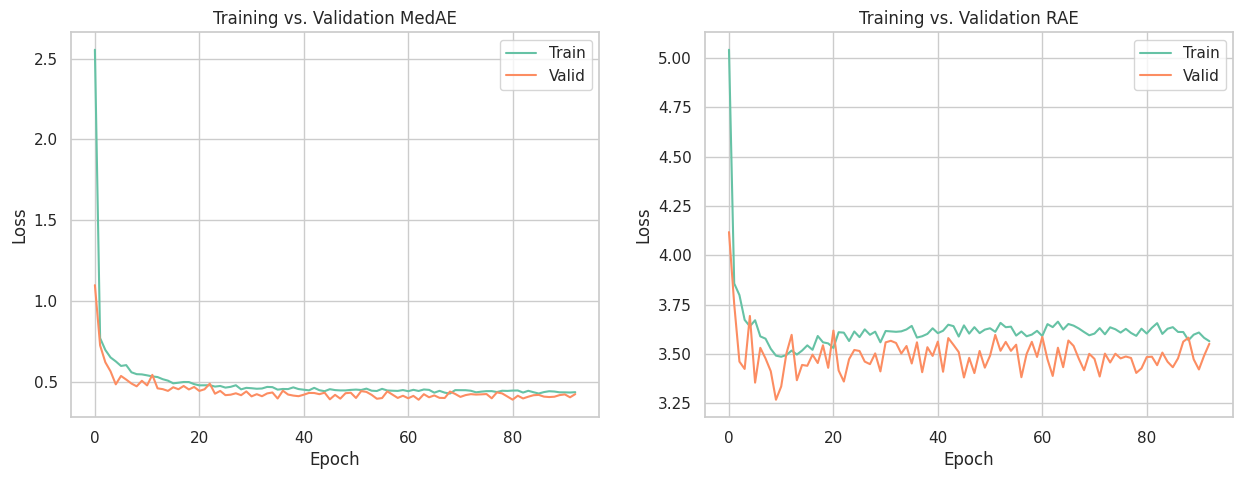

In [50]:
epochs = 93

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(np.arange(epochs), torch.tensor(lnn.epoch_losses['train']), label = 'Train')
ax[0].plot(np.arange(epochs), torch.tensor(lnn.epoch_losses['valid']), label = 'Valid')
ax[0].set_title('Training vs. Validation MedAE')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(np.arange(epochs), torch.tensor(lnn.metric_epoch_scores['train']), label = 'Train')
ax[1].plot(np.arange(epochs), torch.tensor(lnn.metric_epoch_scores['valid']), label = 'Valid')
ax[1].set_title('Training vs. Validation RAE')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

## Getting Best Performing Weights 

In [51]:
best_lnn = LightNN.load_from_checkpoint(mc.best_model_path,in_shape = X_train[0].shape[0], 
              out_shape = 1,
              hidden_units = [16, 32],
              metric = RAE, 
              loss_fn = MedAE)
best_lnn

LightNN(
  (metric): RangeAbsoluteError()
  (loss_fn): MedianAbsoluteError()
  (bn): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_stack): Sequential(
    (0): Linear(in_features=14, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): GELU(approximate='none')
  )
  (linear_out): Linear(in_features=32, out_features=1, bias=True)
)

## Predicting on Test Set

In [52]:
trainer.test(best_lnn, oof_test_dataloader)

Testing: |          | 0/? [00:00<?, ?it/s]

Test  -- RAE: 3.7034, Loss: 0.4104



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4082857668399811     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4082857668399811}]

In [53]:
trainer.test(lnn, oof_test_dataloader)

Testing: |          | 0/? [00:00<?, ?it/s]

Test  -- RAE: 3.6772, Loss: 0.4126



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.41096779704093933    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.41096779704093933}]

In [54]:
def predict_w_sample_weights(model, X, y, target, scaler = None, transform = None):
    base_weight = 0.3
    
    if transform is not None:
        X = X.apply(transform)
        target = target.apply(transform)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = random_seed)
    
    if scaler is not None:
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        target = scaler.transform(target)
    
    model.fit(x_train, y_train)
    
    y_ae = np.abs(y_train - model.predict(x_train))
    lower = np.percentile(y_ae, 10)
    upper = np.percentile(y_ae, 75)
    
    sample_weight = base_weight + ((lower < y_ae) & (y_ae < upper))
    
    model.fit(x_train, y_train, sample_weight = sample_weight)
    return model.predict(target)

# 6. Predictions on Test Data + Submission

In [55]:
test_data = test_data.drop('atomicweight_Average', axis = 1)
skew_transform(test_data)

allelectrons_Total - right skewed
density_Total - right skewed
allelectrons_Average - right skewed
val_e_Average - left skewed
ionenergy_Average - left skewed
el_neg_chi_Average - left skewed
R_vdw_element_Average - left skewed
zaratio_Average - left skewed
density_Average - right skewed


## Creating Final Meta Dataset

In [56]:
vr_preds = predict_w_sample_weights(vr, X, y, test_data, scaler = r_scaler).reshape(-1, 1)

stack_preds = predict_w_sample_weights(stack, X, y, test_data, scaler = r_scaler).reshape(-1, 1)

we_preds = predict_w_sample_weights(we, X, y, test_data, scaler = r_scaler).reshape(-1, 1)

lgbmr = LGBMRegressor(**lgbm_params)
lgbmr_preds = predict_w_sample_weights(lgbmr, X, y, test_data, scaler = r_scaler).reshape(-1, 1)

In [57]:
blend_stack = np.hstack((we_preds, vr_preds, stack_preds, lgbmr_preds))
blend_stack

array([[2.79986677, 2.72306006, 2.53834361, 2.5612786 ],
       [2.57085488, 2.49673655, 2.62165749, 2.5493684 ],
       [6.09038132, 6.03293368, 5.96250491, 5.91563242],
       ...,
       [4.75357519, 4.80356496, 4.98406125, 4.75538474],
       [4.59065815, 4.25301412, 4.35937454, 4.53643263],
       [3.34017895, 3.41981774, 3.56509651, 3.31802579]])

In [58]:
blend_pred_df = pd.DataFrame(blend_stack, columns = ['WeightedEnsemble', 'VotingRegressor', 'StackingRegressor', 'LGBMRegressor'])
test_w_blend = pd.concat([test_data, blend_pred_df], axis = 1)
test_w_blend.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,WeightedEnsemble,VotingRegressor,StackingRegressor,LGBMRegressor
0,6.785588,4.807458,3.593469,27.8784,87.804096,5.280804,3.637412,1.200000,0.213351,1.027685,2.799867,2.723060,2.538344,2.561279
1,4.510860,2.391691,2.944439,31.3600,146.078648,8.225424,2.729104,0.864000,0.226763,0.880431,2.570855,2.496737,2.621657,2.549368
2,4.762174,2.171108,2.533697,23.0400,121.525048,6.990736,3.218436,0.960000,0.249514,0.581288,6.090381,6.032934,5.962505,5.915632
3,4.615121,2.313327,2.397895,23.0400,146.078648,7.997584,2.762244,0.792000,0.245813,0.790573,4.456166,4.437071,4.585647,4.468079
4,4.025352,1.615420,2.484907,16.0000,127.259833,6.027025,3.062500,0.893333,0.226666,0.659880,5.066229,4.983765,5.171758,4.918743


In [59]:
test_w_blend_scaled = r_scaler.fit_transform(test_w_blend)

In [60]:
# Best weights LNN preds
best_lnn.eval()
with torch.inference_mode():
    best_lnn_preds = best_lnn(torch.tensor(test_w_blend_scaled, dtype = torch.float32))

best_lnn_preds = best_lnn_preds.detach().numpy()
best_lnn_preds[:5]

array([[2.4759188],
       [2.4656394],
       [5.8704534],
       [5.2546206],
       [5.504393 ]], dtype=float32)

In [61]:
# Normal LNN Preds
lnn.eval()
with torch.inference_mode():
    lnn_preds = lnn(torch.tensor(test_w_blend_scaled, dtype = torch.float32))

lnn_preds = lnn_preds.detach().numpy()
lnn_preds[:5]

array([[2.5506935],
       [2.4818053],
       [5.8266916],
       [5.2621765],
       [5.5763073]], dtype=float32)

In [62]:
# Create submission
submission = pd.DataFrame()
submission['id'] = ss['id']
submission['Hardness'] = best_lnn_preds
submission.head()

,id,Hardness
0,10407,2.475919
1,10408,2.465639
2,10409,5.870453
3,10410,5.254621
4,10411,5.504393


In [63]:
submission.to_csv('submission.csv', index = False, header = True)